In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator

from manuscript_functions.colors import default_hex, patient_to_id, timepoints_cmap, default_rgba

In [2]:
sns.set(font="Arial", style="ticks")
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"


In [3]:
fig_dir = "/Users/adr/Box/iPC_AML/Documents/Manuscript/Figures/Figure4/"

# Distance in latent space

In [4]:
patient_meta = pd.read_excel("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/metadata_patients_20221007.xlsx")
patient_meta.rename(columns={"USI": "patient_id"}, inplace=True)
patient_meta["Days diff"] = patient_meta["Days to OS from study entry"] - patient_meta["Days to relapse from study entry"]


patient_meta["Fusion"] = ["KMT2A" if "KMT2A" in label else label for label in patient_meta["Fusion"].astype(str)]
patient_meta["Fusion"] = ["other" if not label  in ["KMT2A", "RUNX1_RUNX1T1"] else label for label in patient_meta["Fusion"] ]
patient_meta["PatientID"] = [patient_to_id[p] for p in patient_meta["patient_id"]]

In [5]:
distances = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Intermediate_data/Distance/diag_relapse_dists.csv",
                       index_col=0)
plot_data = pd.merge(patient_meta, distances, how="right", on="patient_id")


In [6]:
stat, p_val = mannwhitneyu(x=plot_data.loc[plot_data["Fusion"]=="KMT2A", "euclidean_dist"],
                           y=plot_data.loc[plot_data["Fusion"]=="RUNX1_RUNX1T1", "euclidean_dist"],
                           alternative="greater")
print(p_val)

0.009523809523809525


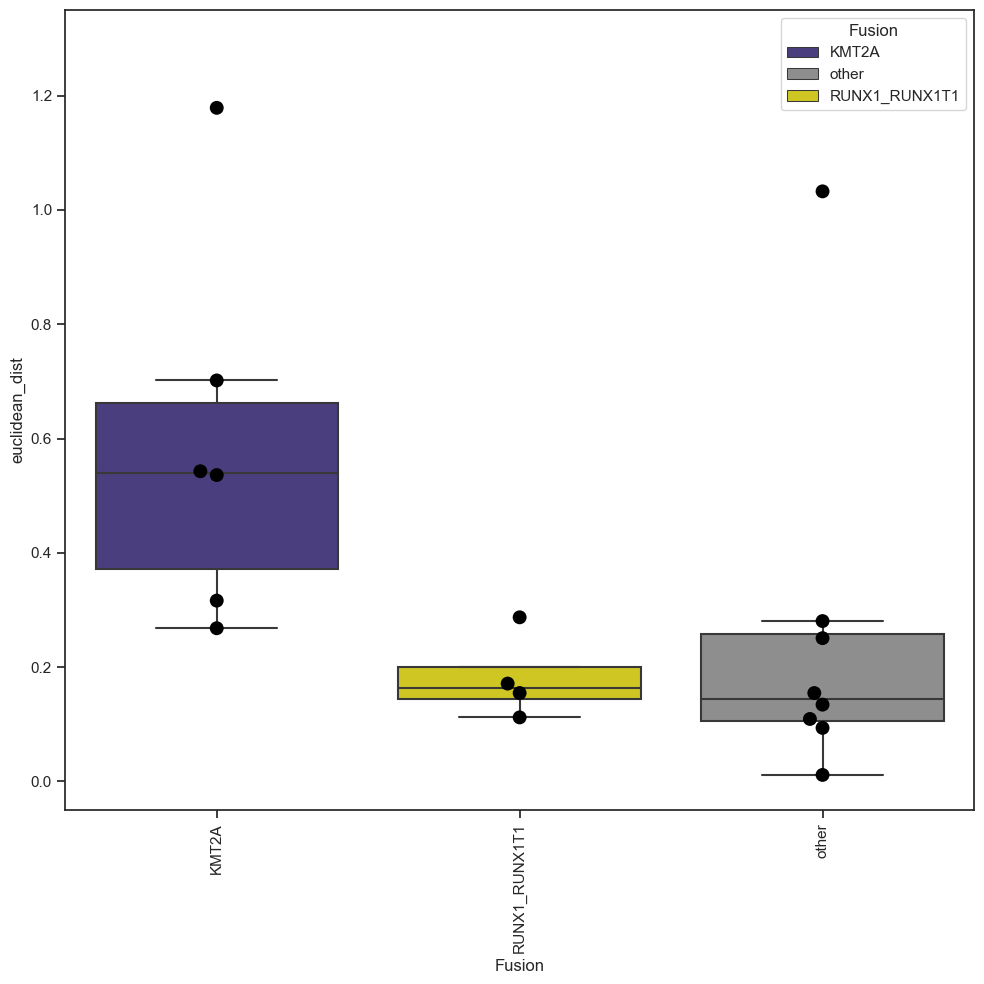

In [7]:
plt.figure(figsize=(10,10))
ax = sns.boxplot(data=plot_data, x="Fusion", y="euclidean_dist", hue="Fusion", palette={"KMT2A": default_hex["blue"],
                                                                                  "RUNX1_RUNX1T1": default_hex["yellow"],
                                                                                  "other": default_hex["grey"]},
                dodge=False, order=["KMT2A", "RUNX1_RUNX1T1", "other"])
sns.swarmplot(data=plot_data, x="Fusion", y="euclidean_dist", 
                s=10, color="black", ax=ax, order=["KMT2A", "RUNX1_RUNX1T1", "other"])
p = plt.xticks(rotation=90)
plt.tight_layout()
plt.ylim((-0.05,1.35))
plt.savefig(f"{fig_dir}euclidean_distance_cell_types_fusion.pdf")
plt.show()

# Changes in cells postive for markers

In [8]:
trans_norm_expr = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/Transformed_normalised/myeloid_expr_transformed_normalised.csv", index_col=0)
trans_norm_expr.reset_index(drop=True, inplace=True)
meta = pd.read_csv("/Users/adr/Box/iPC_work/Local_files_for_paper/Updated/monocytic_meta_TP_patient_file_cluster.csv", index_col=0)
meta["PatientID"] = [patient_to_id[p] for p in meta["patient_id"]]
meta


,time_point,patient_id,file_id,cluster_id,PatientID
0,Diagnosis,PAUMTZ,0,20,P1
1,Diagnosis,PAUMTZ,0,20,P1
2,Diagnosis,PAUMTZ,0,20,P1
3,Diagnosis,PAUMTZ,0,20,P1
4,Diagnosis,PAUMTZ,0,20,P1
...,...,...,...,...,...
350245,EOI I,TEST12378,42,23,P21
350246,EOI I,TEST12378,42,23,P21
350247,EOI I,TEST12378,42,23,P21
350248,EOI I,TEST12378,42,23,P21


In [9]:
sel = meta.loc[meta["time_point"]!="EOI I", ["PatientID", "time_point"]].drop_duplicates().groupby("PatientID").size() == 2
diag_rel_patients = sel[sel].index.values
markers = trans_norm_expr.columns
pred = np.load("/Users/adr/Box/iPC_work/Local_files_for_paper/Model/Experiments/sklear_models/LCO/L1O/svm_prediction.npy")
selection_bool = (pred=="Blast") & (meta["time_point"] != "EOI I")

In [10]:
cmap = {"blue": sns.color_palette("vlag")[0], 
      "red": sns.color_palette("vlag")[-1]}

marker_thresholds = {
    "FSC_A" : 0.,
    "SSC_A" : 0.,
    "CD3"   : 0.47,
    "CD4"   : 0.31,
    "CD8"   : 0.59,
    "CD11b" : 0.31,
    "CD11c" : 0.4,
    "CD13"  : 0.3,
    "CD14"  : 0.25,
    "CD19"  : 0.61,
    "CD33"  : 0.36,
    "CD34"  : 0.38,
    "CD35"  : 0.36,
    "CD38"  : 0.29,
    "CD45"  : 0.36,
    "CD45RA": 0.3,
    "CD64"  : 0.36,
    "CD56"  : 0.33,
    "CD71"  : 0.39,
    "CD117" : 0.26,
    "CD123" : 0.31,
    "CD203c": 0.42,
    "HLA_DR": 0.27}
marker_thresh_df = pd.DataFrame(marker_thresholds, index=trans_norm_expr.index)
marker_thresh_df = marker_thresh_df[markers]

In [11]:
expr_meta = trans_norm_expr[trans_norm_expr > marker_thresh_df]
expr_meta[["PatientID", "time_point"]] = meta[["PatientID", "time_point"]]
expr_meta = expr_meta[selection_bool & (expr_meta["PatientID"].isin(diag_rel_patients))]
median_expr = expr_meta.groupby(["PatientID", "time_point"]).median().reset_index(drop=False)
median_expr['PatientID'] = median_expr["PatientID"].astype('category')

count_meta = (trans_norm_expr > marker_thresh_df).astype(int)
count_meta[["PatientID", "time_point"]] = meta[["PatientID", "time_point"]]
count_meta = count_meta[selection_bool & (count_meta["PatientID"].isin(diag_rel_patients))]

num_pos_cells = count_meta.groupby(["PatientID", "time_point"]).sum().reset_index(drop=False)
num_pos_cells[markers] = num_pos_cells[markers].div(num_pos_cells["FSC_A"], axis=0) # Since FCS_A and SSC_A have no threshold this is the number of blasts

plot_data = num_pos_cells.copy()
plot_data[markers] = plot_data[markers].diff()
plot_data = plot_data[num_pos_cells["time_point"]=="Relapse"].drop("time_point", axis=1)
plot_data = pd.melt(plot_data, id_vars="PatientID", value_name="difference", var_name="marker")
plot_data["color"] = ["blue" if diff < 0 else "red" for diff in plot_data["difference"]]

In [12]:
difference = num_pos_cells.set_index(["PatientID", "time_point"]).diff().reset_index(drop=False)
difference = difference[difference["time_point"]=="Relapse"].drop("time_point", axis=1)

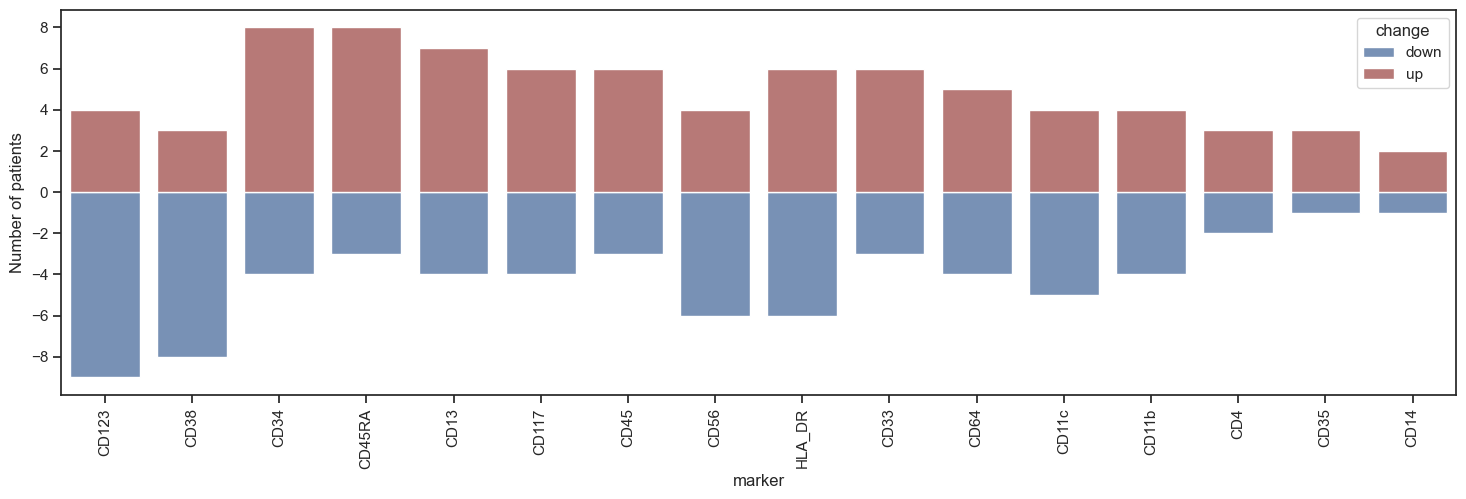

In [13]:
tresh = 0.05
temp = difference.melt(id_vars="PatientID", var_name="marker", value_name="difference")
pos_temp = temp[temp["difference"]>tresh]
pos_change = temp[temp["difference"]>tresh].groupby("marker").size().reset_index(drop=False)
neg_change = temp[temp["difference"]<-tresh].groupby("marker").size().reset_index(drop=False)

plot_d = pd.concat([pos_change, neg_change], axis=0, keys=["up", "down"], names=["change", ""]).reset_index("change", drop=False).reset_index(drop=True)
plot_d = plot_d.sort_values(0, ascending=False).rename(columns={0: "Number of patients"})

plot_d.loc[plot_d["change"]=="down", "Number of patients"] = -1*plot_d.loc[plot_d["change"]=="down", "Number of patients"]
plt.figure(figsize=(18,5))
ax = sns.barplot(data=plot_d, x="marker", y="Number of patients", hue="change", palette={"up": cmap["red"], "down": cmap["blue"]}, dodge=False)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
t = plt.xticks(rotation=90)
plt.savefig(f"{fig_dir}overview_marker_changes_num_patients_thresh_{tresh}.pdf")

In [93]:
len(diag_rel_patients)

18

In [92]:
len(pos_temp["PatientID"].unique())

16

In [94]:
set(diag_rel_patients).difference(pos_temp["PatientID"].unique()
                                 )

{'P17', 'P3'}

In [132]:
plot_d["abs_n_patients"] = abs(plot_d["Number of patients"])
plot_d["frac_of_patients"] = plot_d["abs_n_patients"]/len(diag_rel_patients)
plot_d = plot_d.sort_values(["marker", "change"])
plot_d = plot_d[["marker", "change", "frac_of_patients", "Number of patients", "abs_n_patients"]]

total_change = plot_d.groupby("marker").sum().reset_index(drop=False)
total_change["frac_unchanged"] = 1-total_change["frac_of_patients"]
total_change = total_change.rename(columns={"frac_of_patients": "frac_changed",
                                           "abs_n_patients": "Number of patients",
                                           "Number of patients": "Patients diff"})
total_change = total_change[["marker", "frac_changed", "frac_unchanged", "Number of patients"]]


In [134]:
plot_d.to_excel(f"{fig_dir}4C_frac_of_patients_with_change_up_down_per_marker.xlsx",
                        index=False)
total_change.to_excel(f"{fig_dir}4C_frac_of_patients_with_change_per_marker.xlsx",
                        index=False)

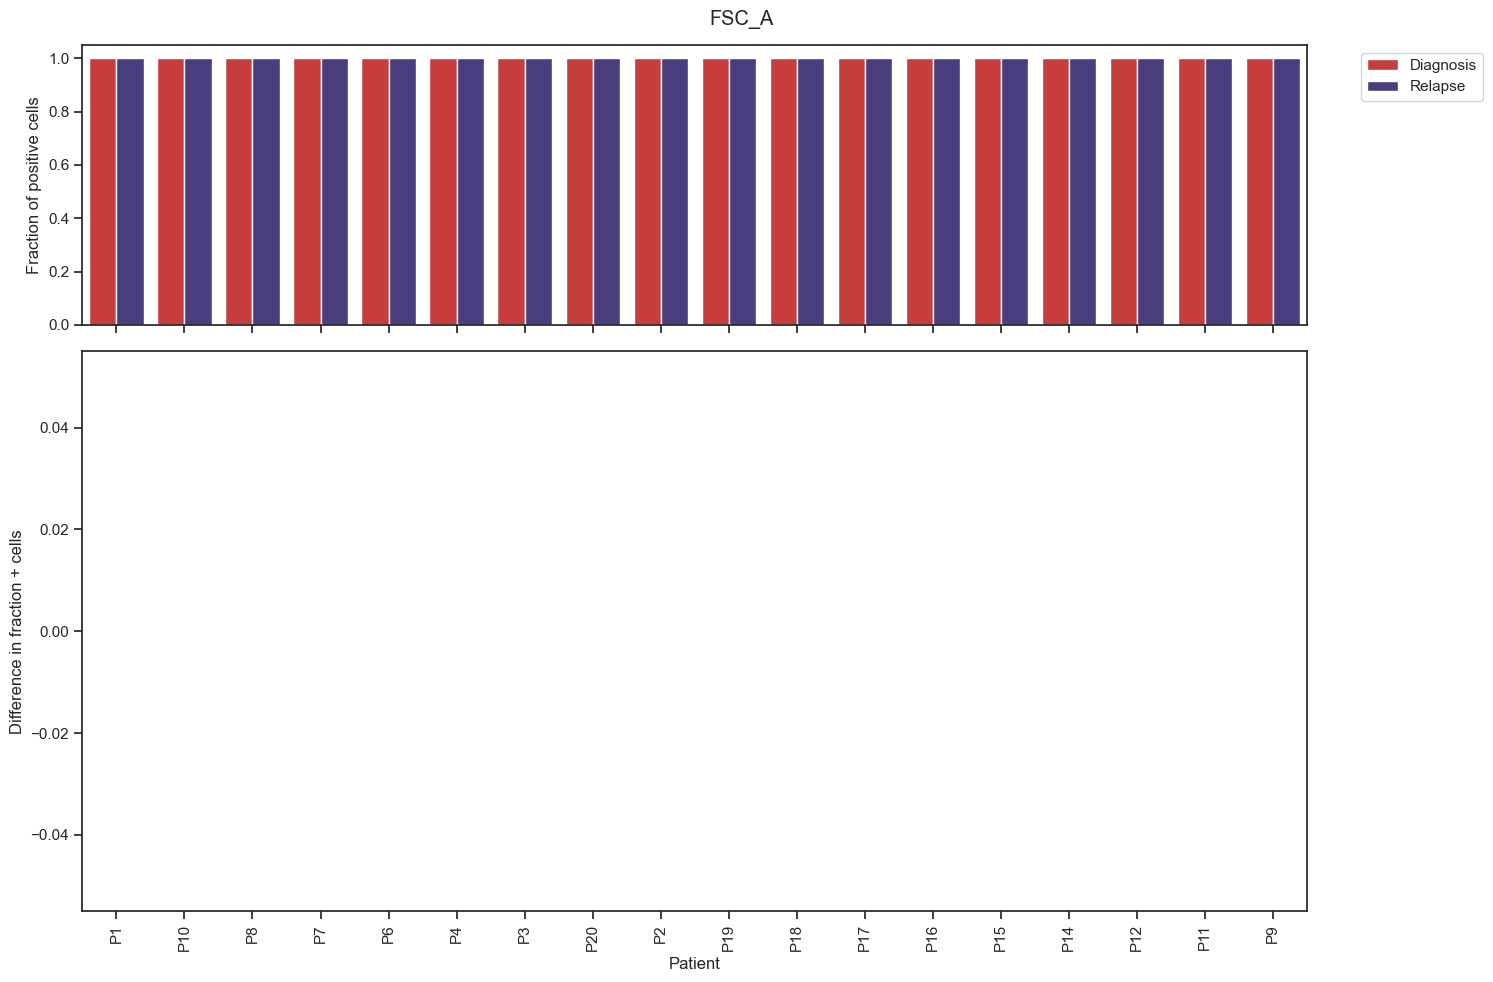

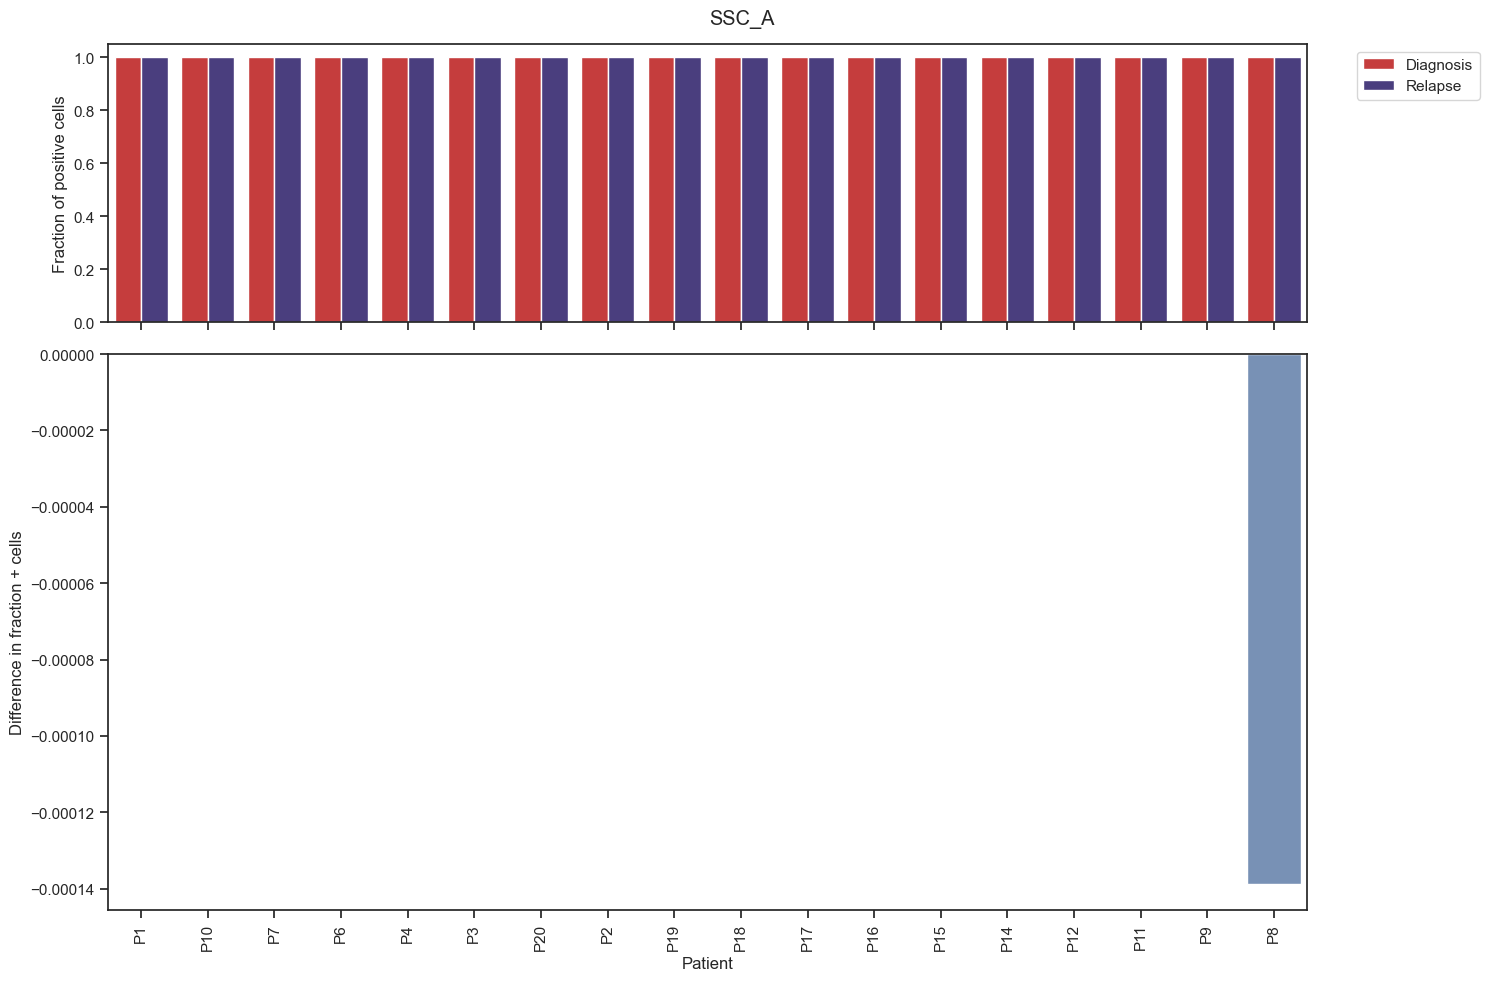

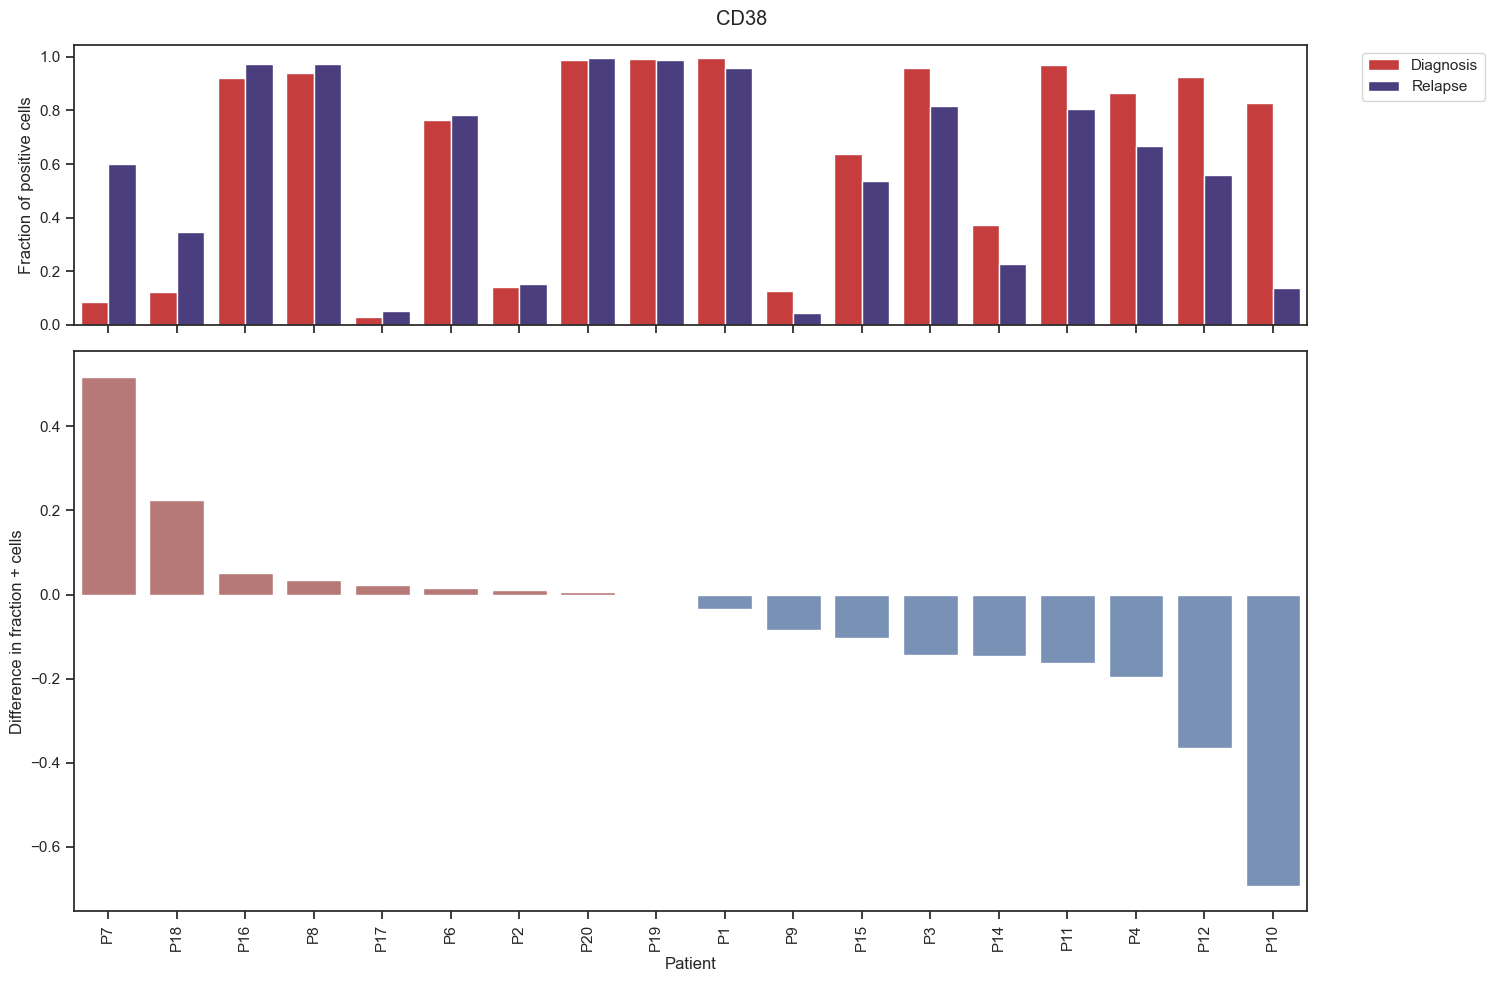

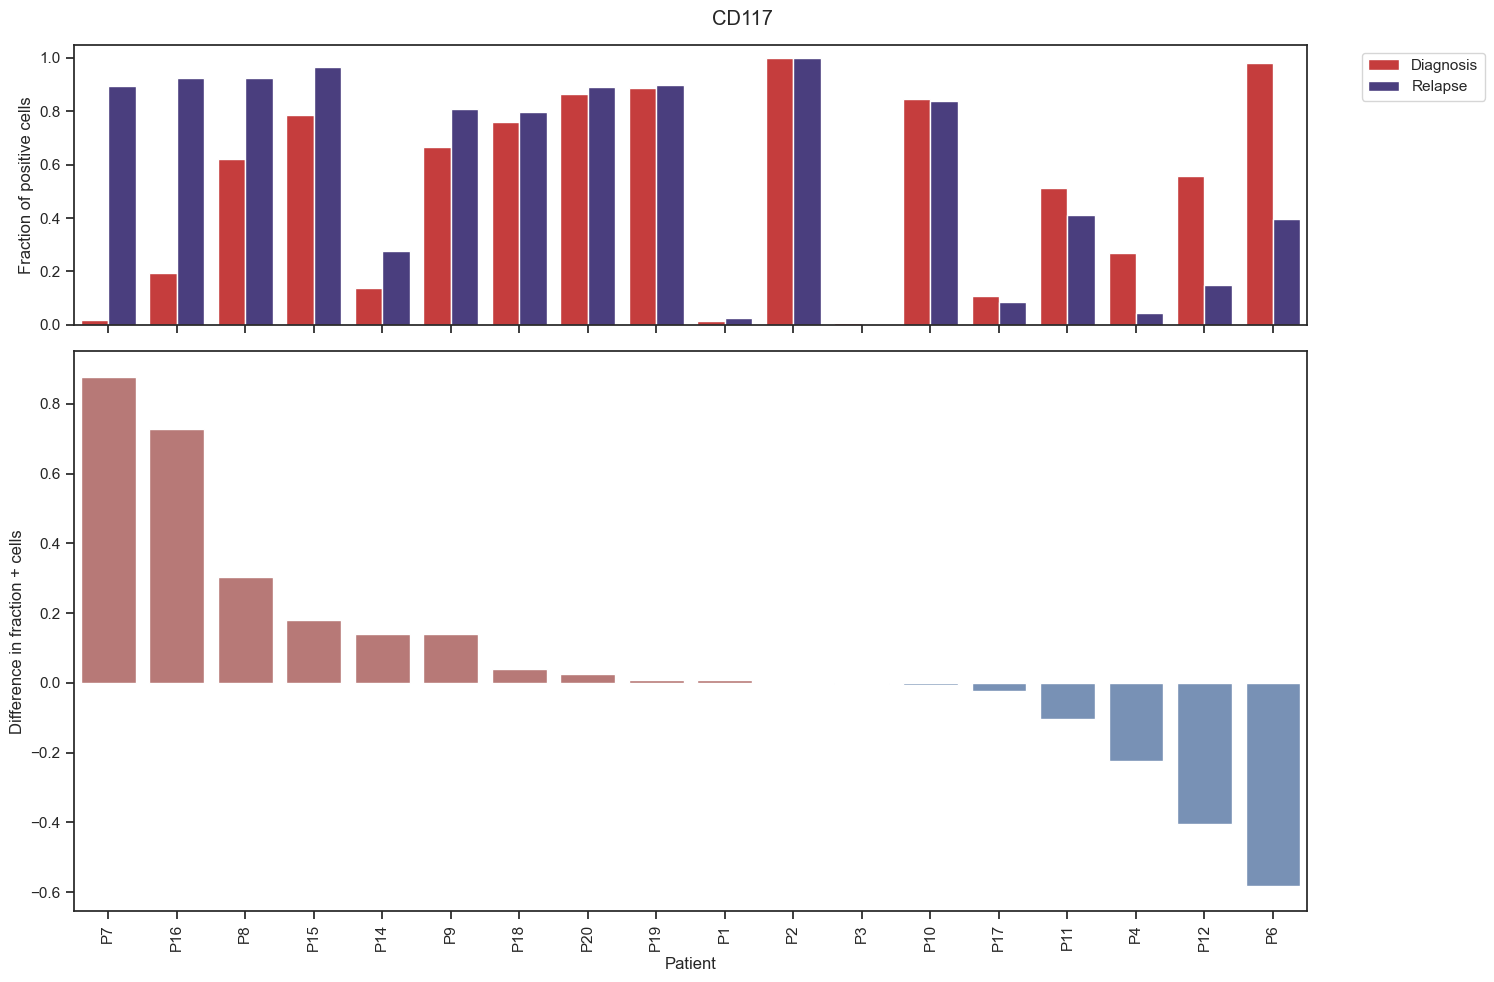

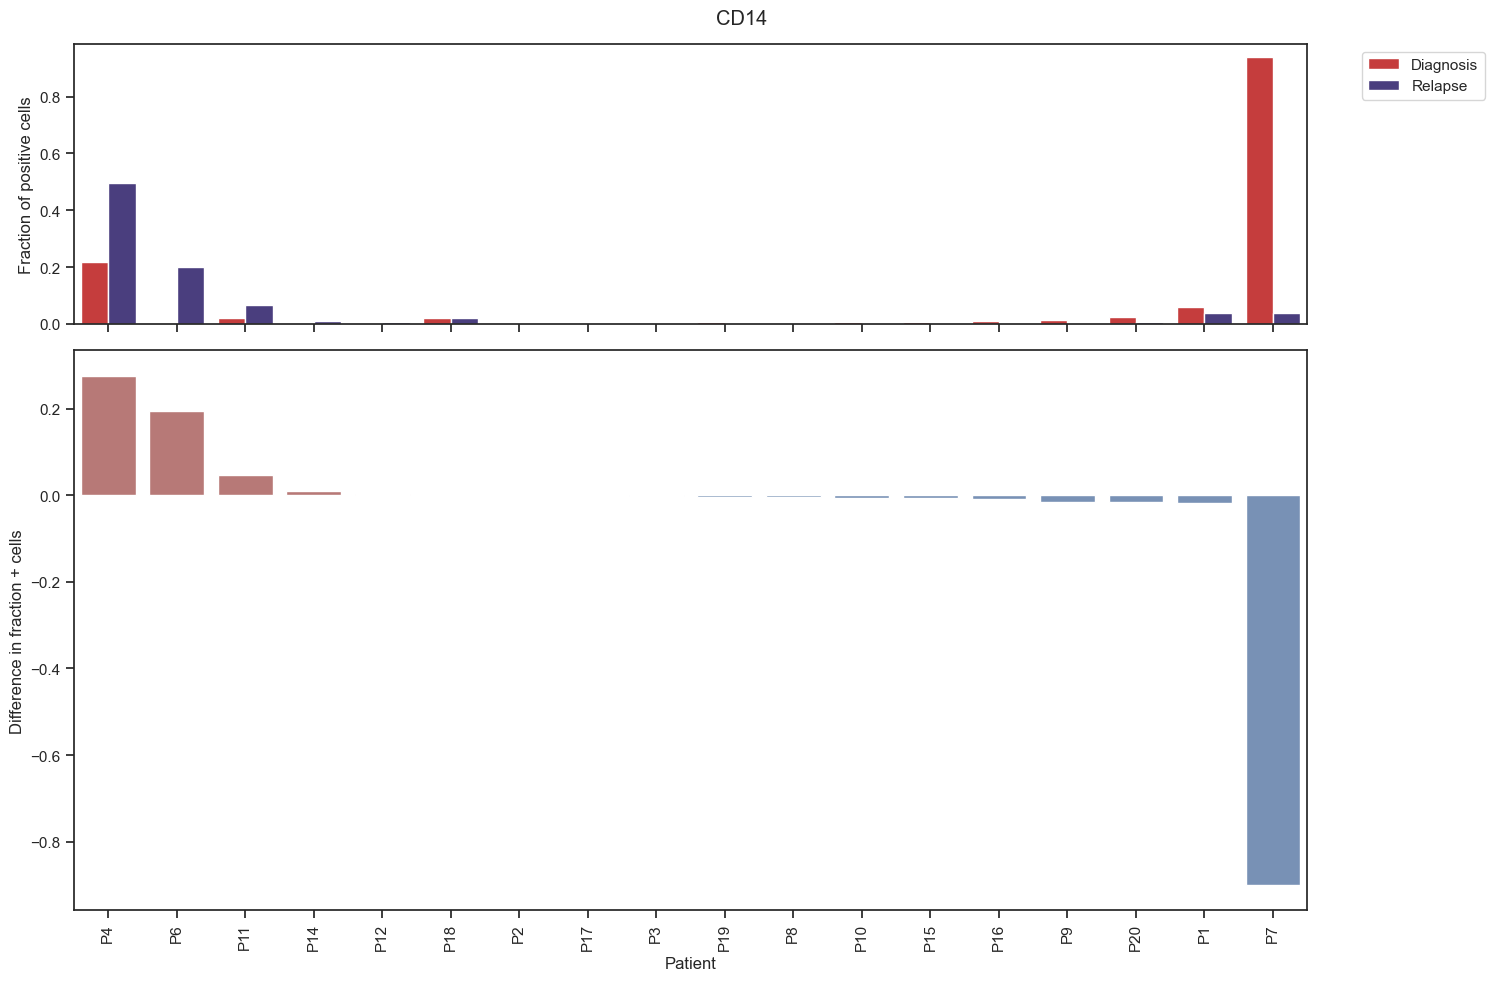

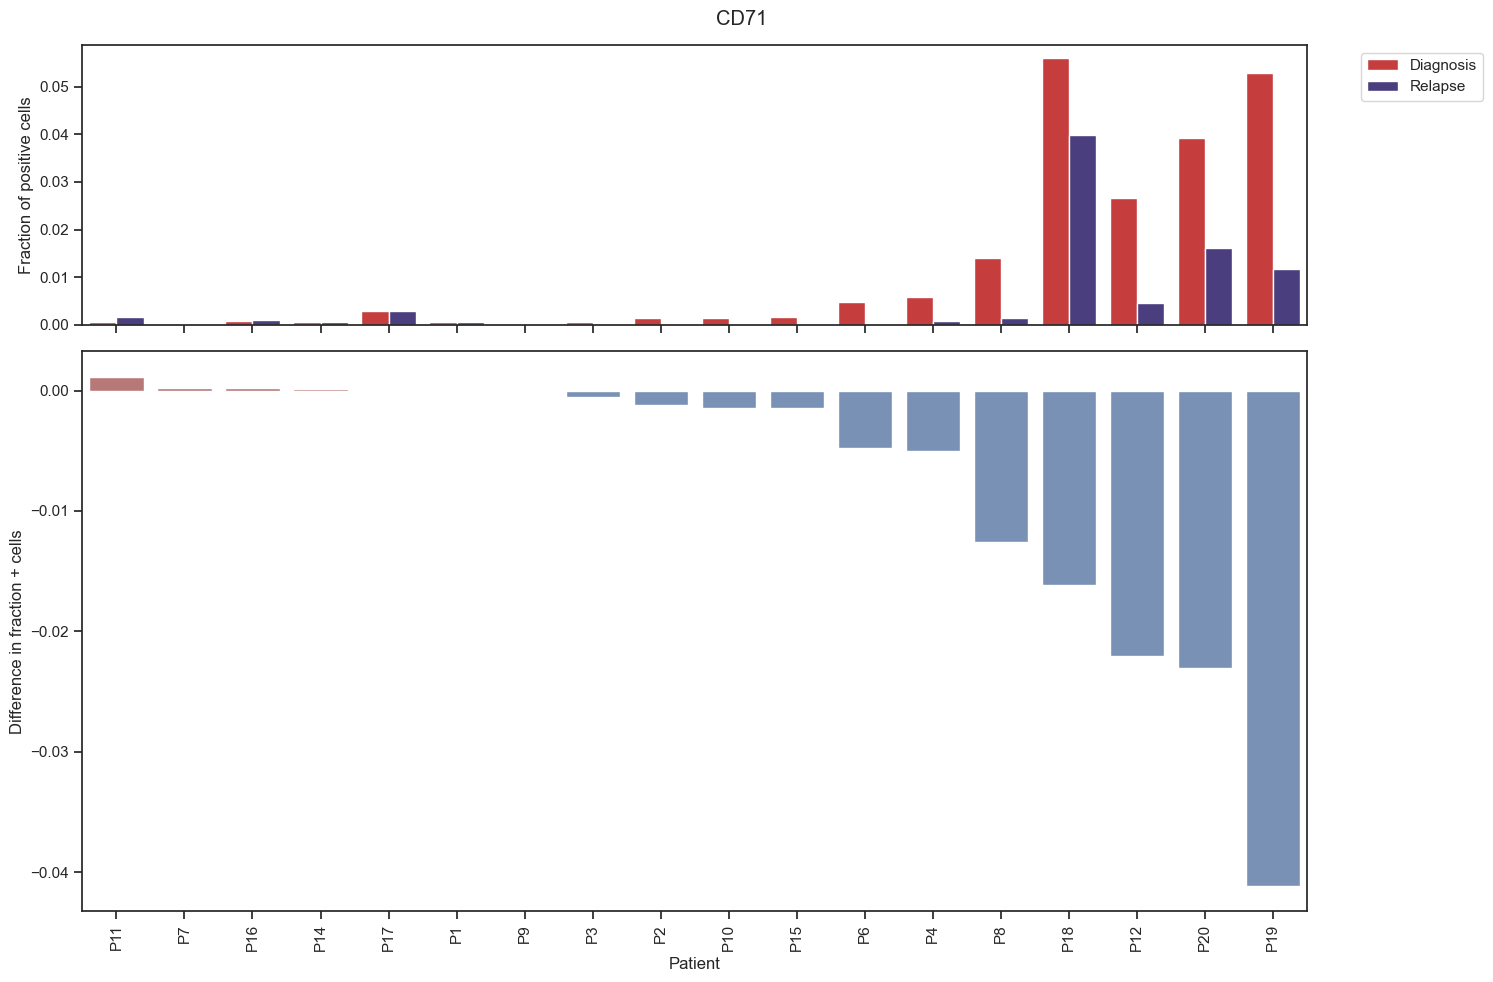

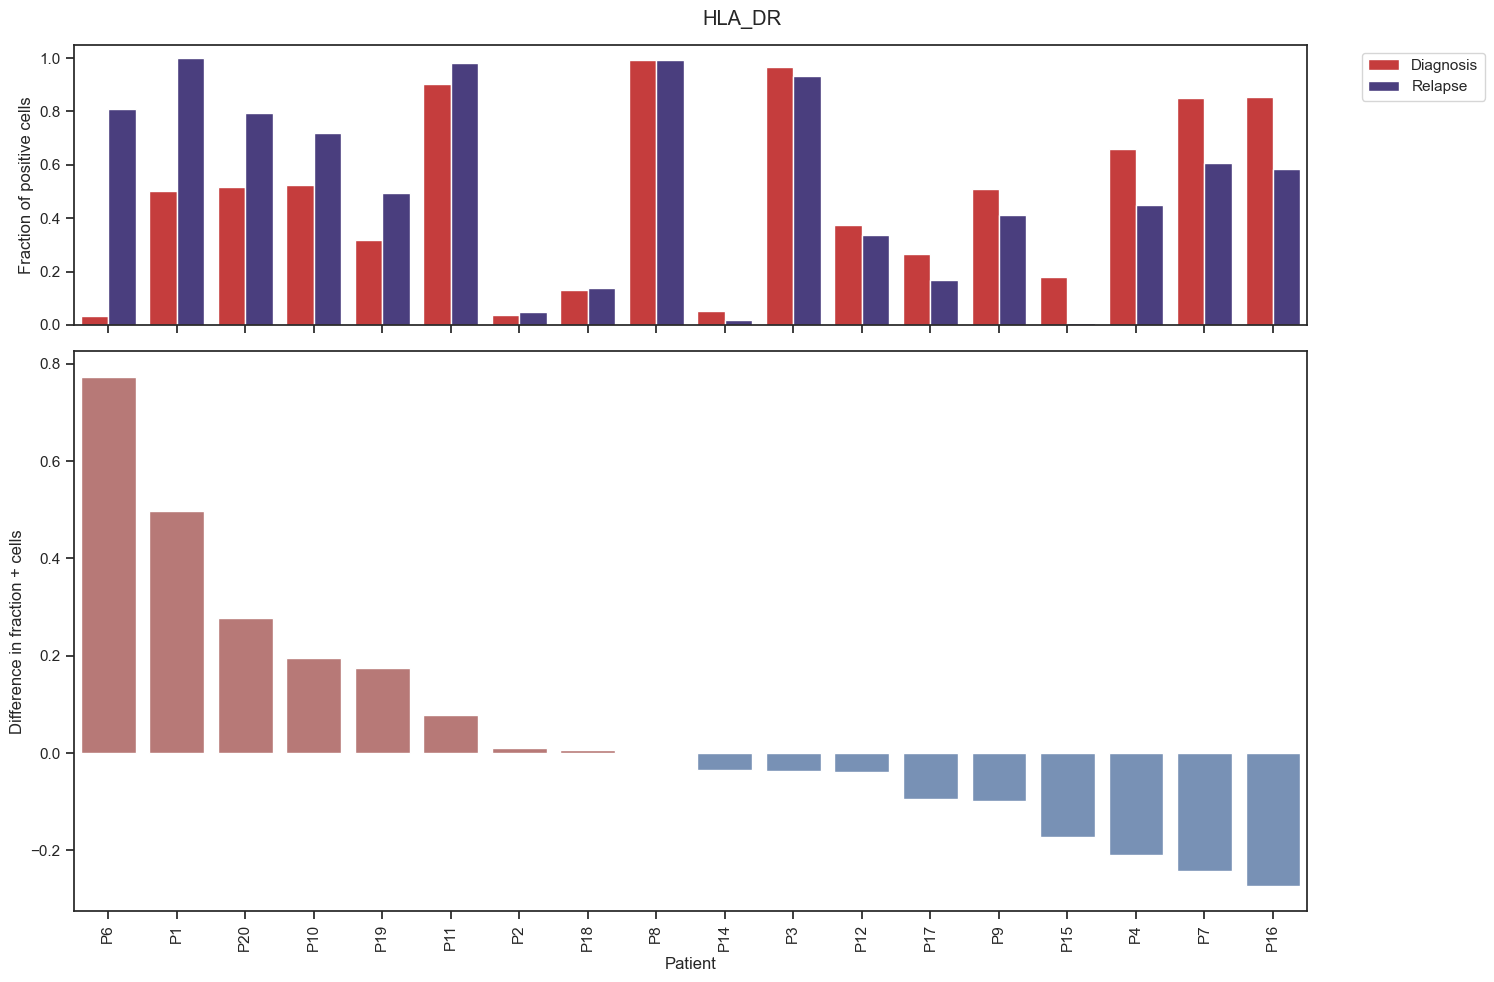

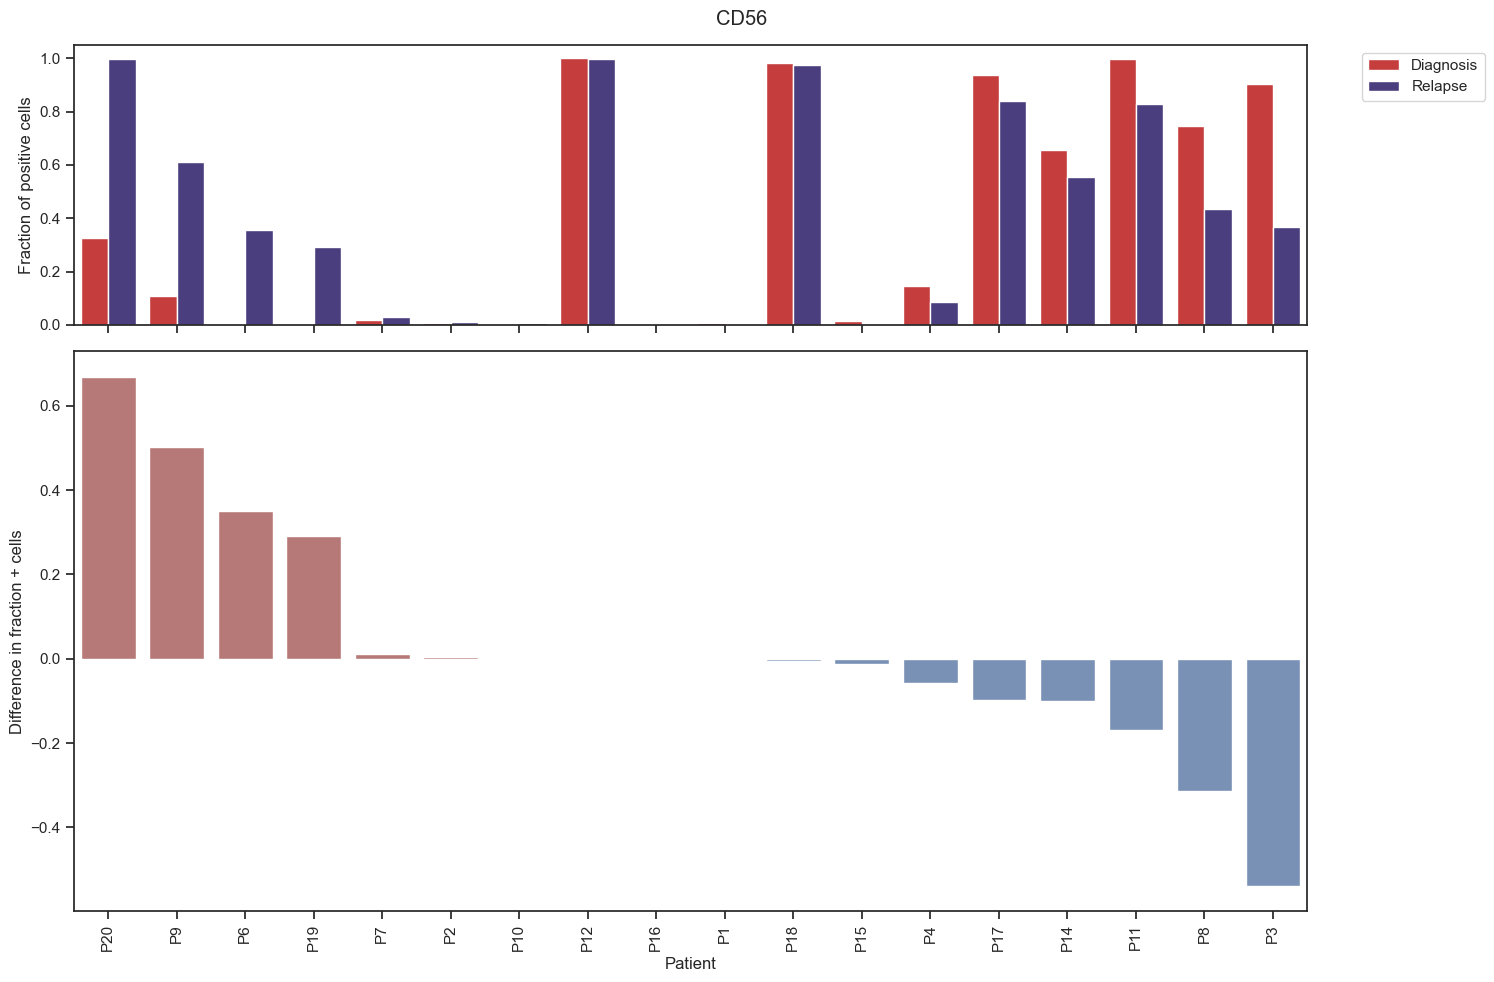

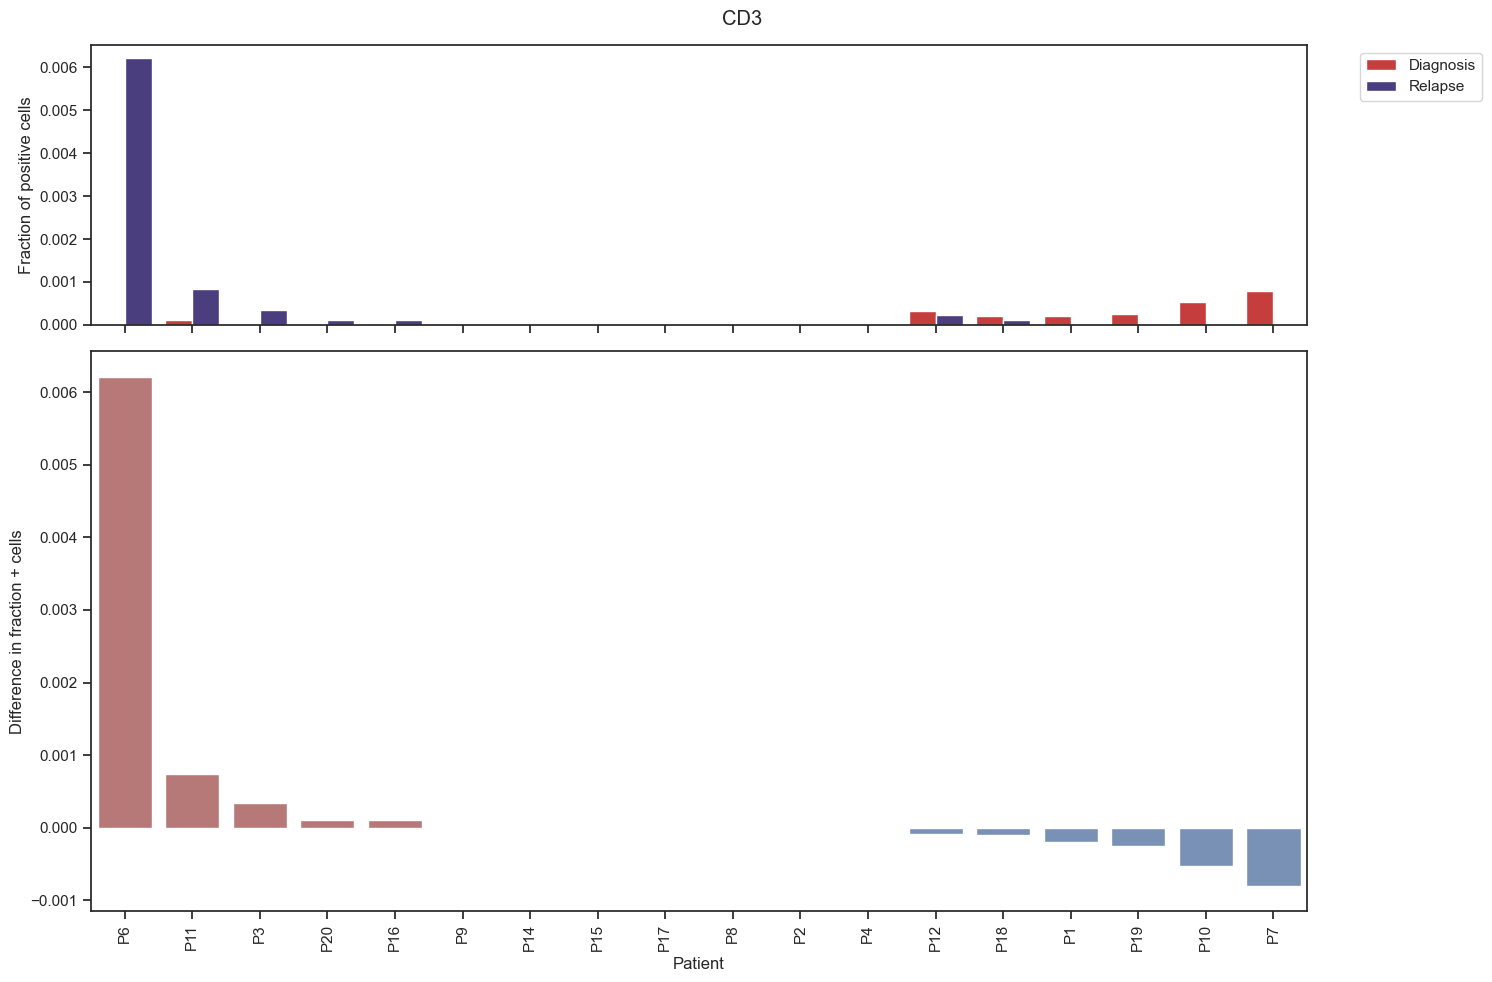

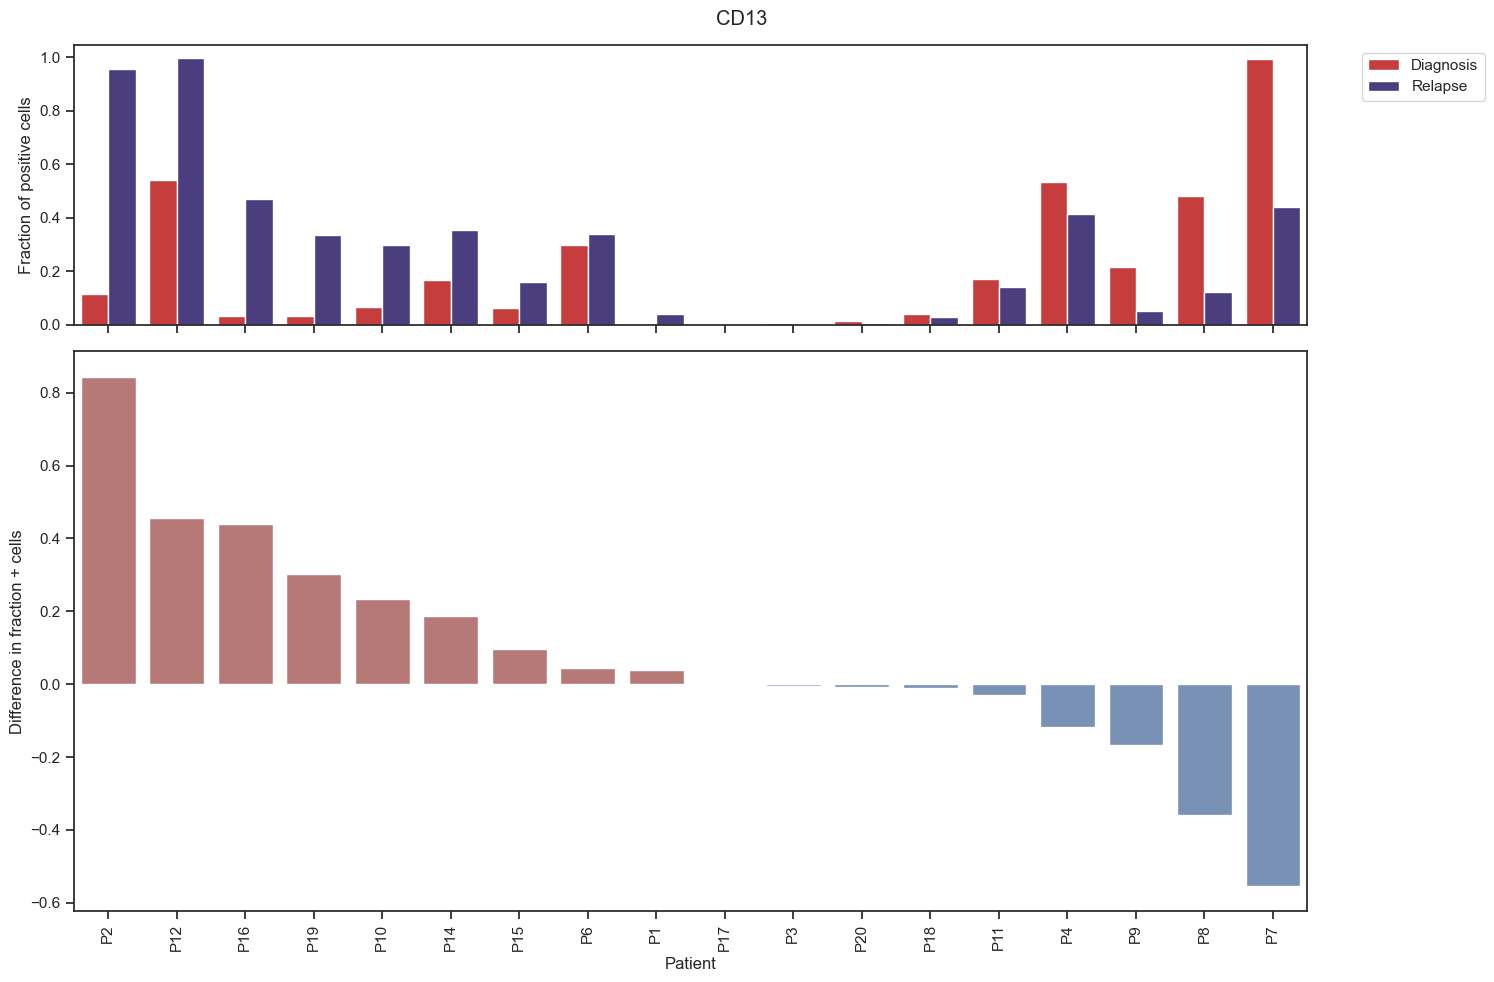

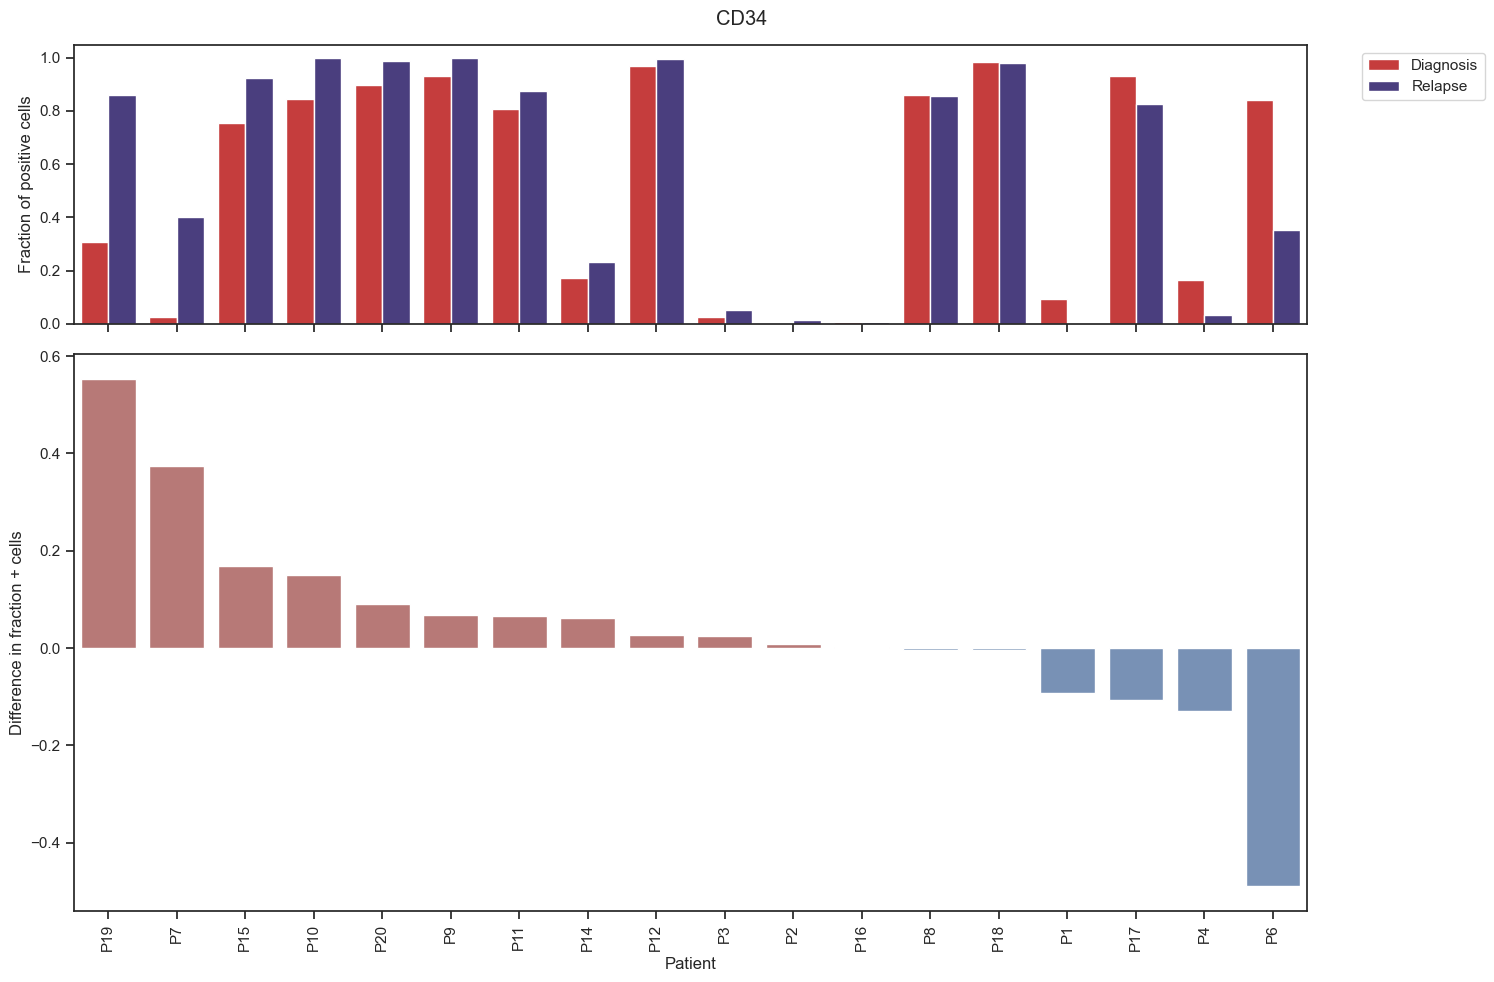

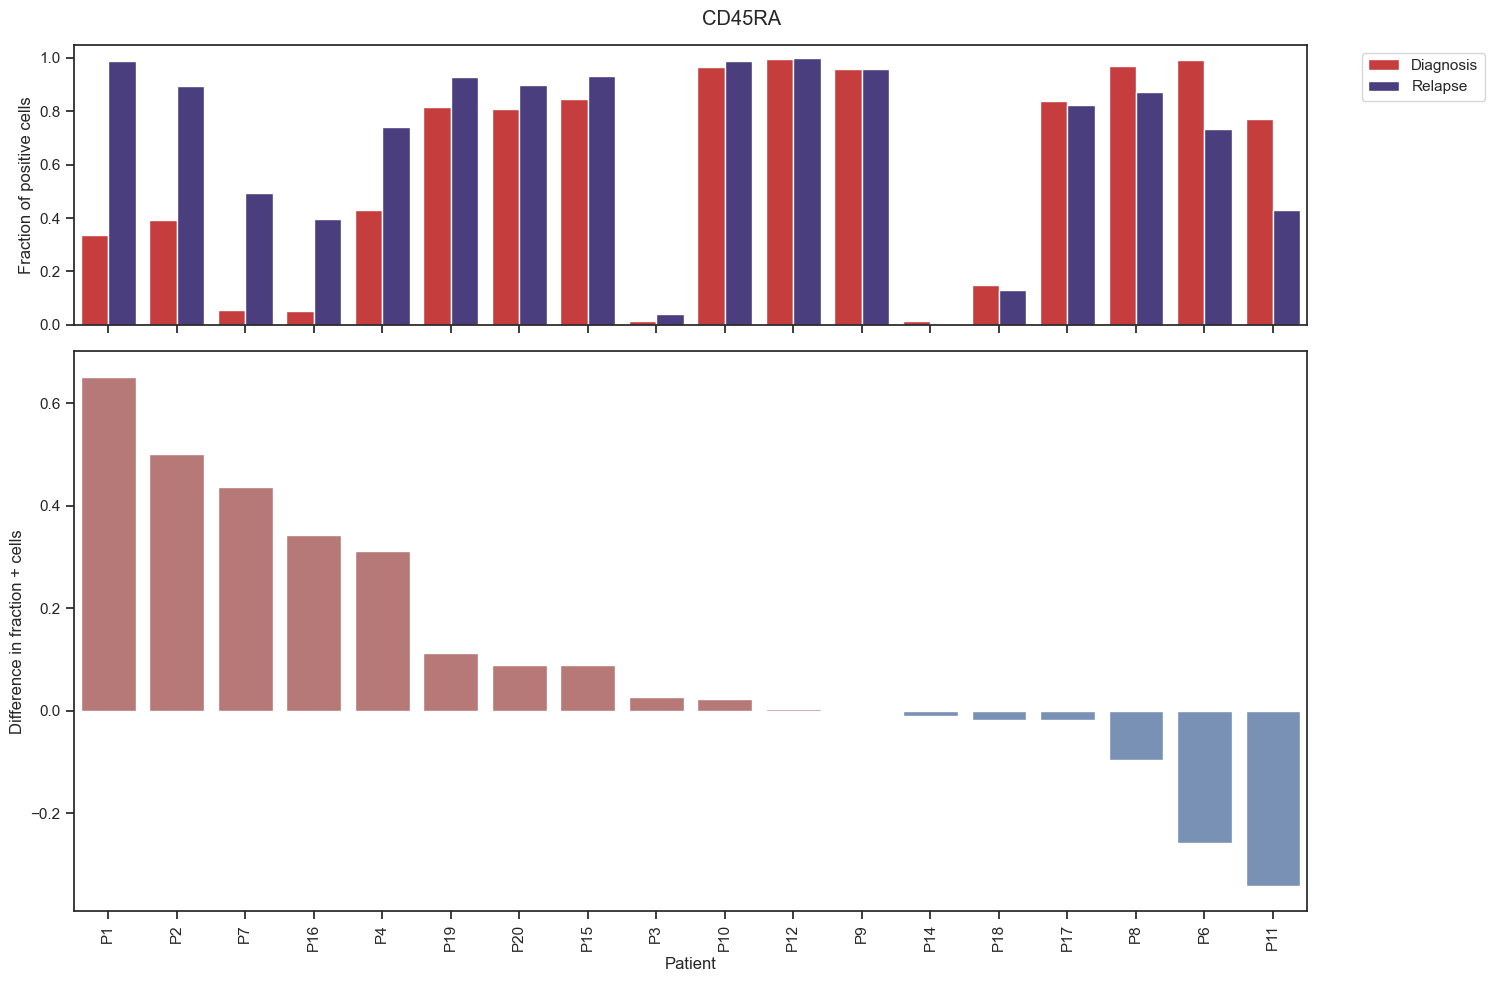

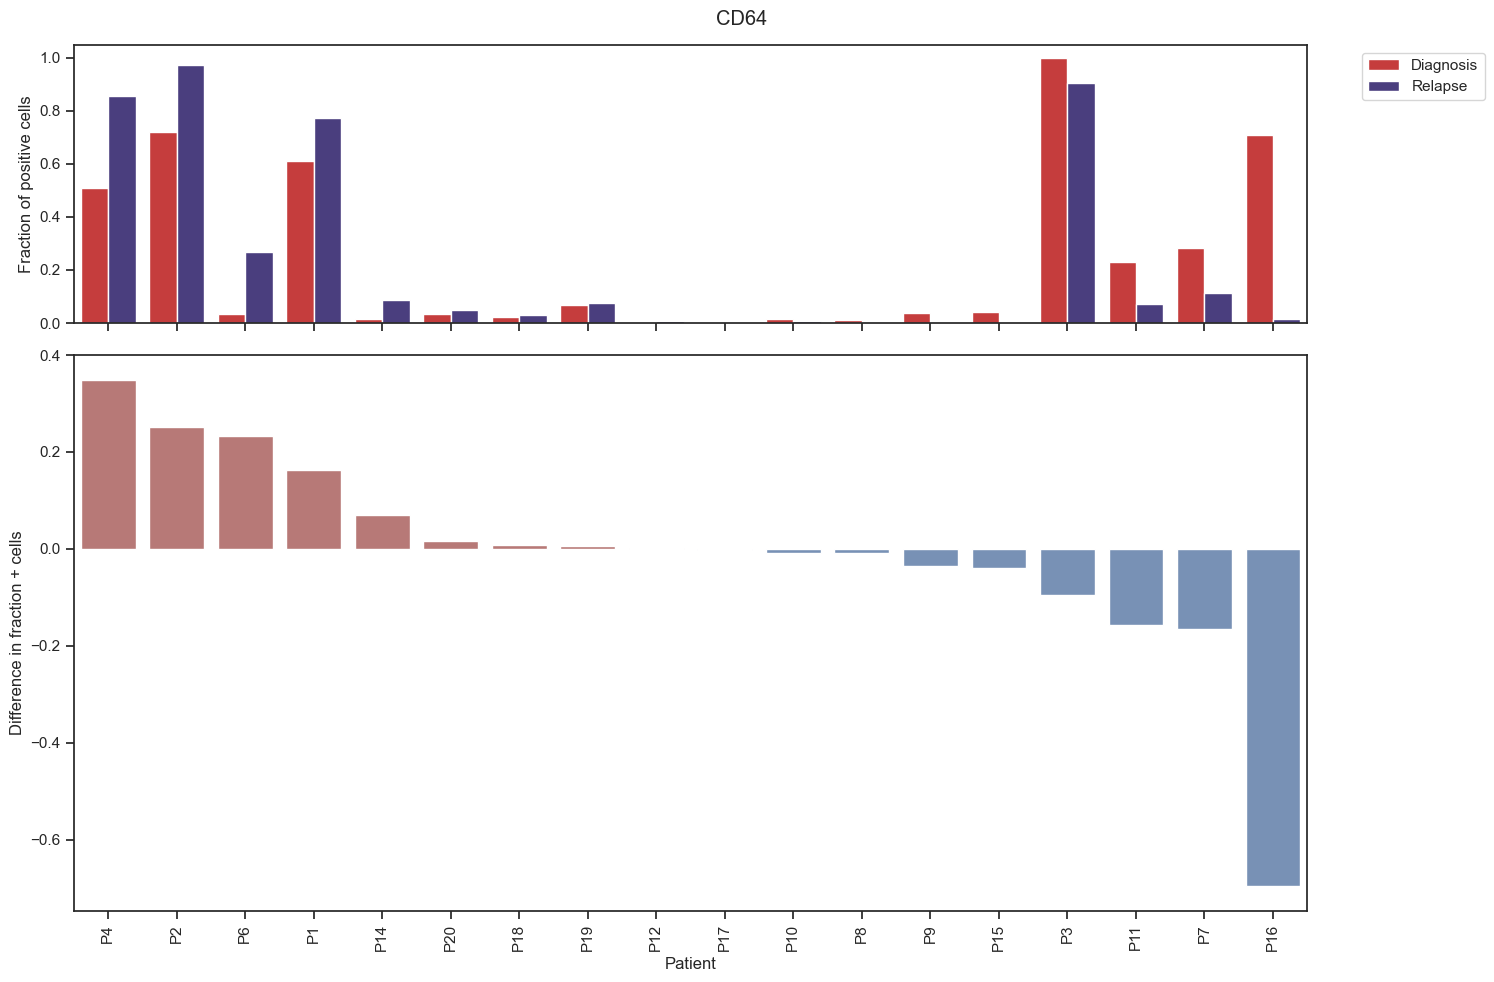

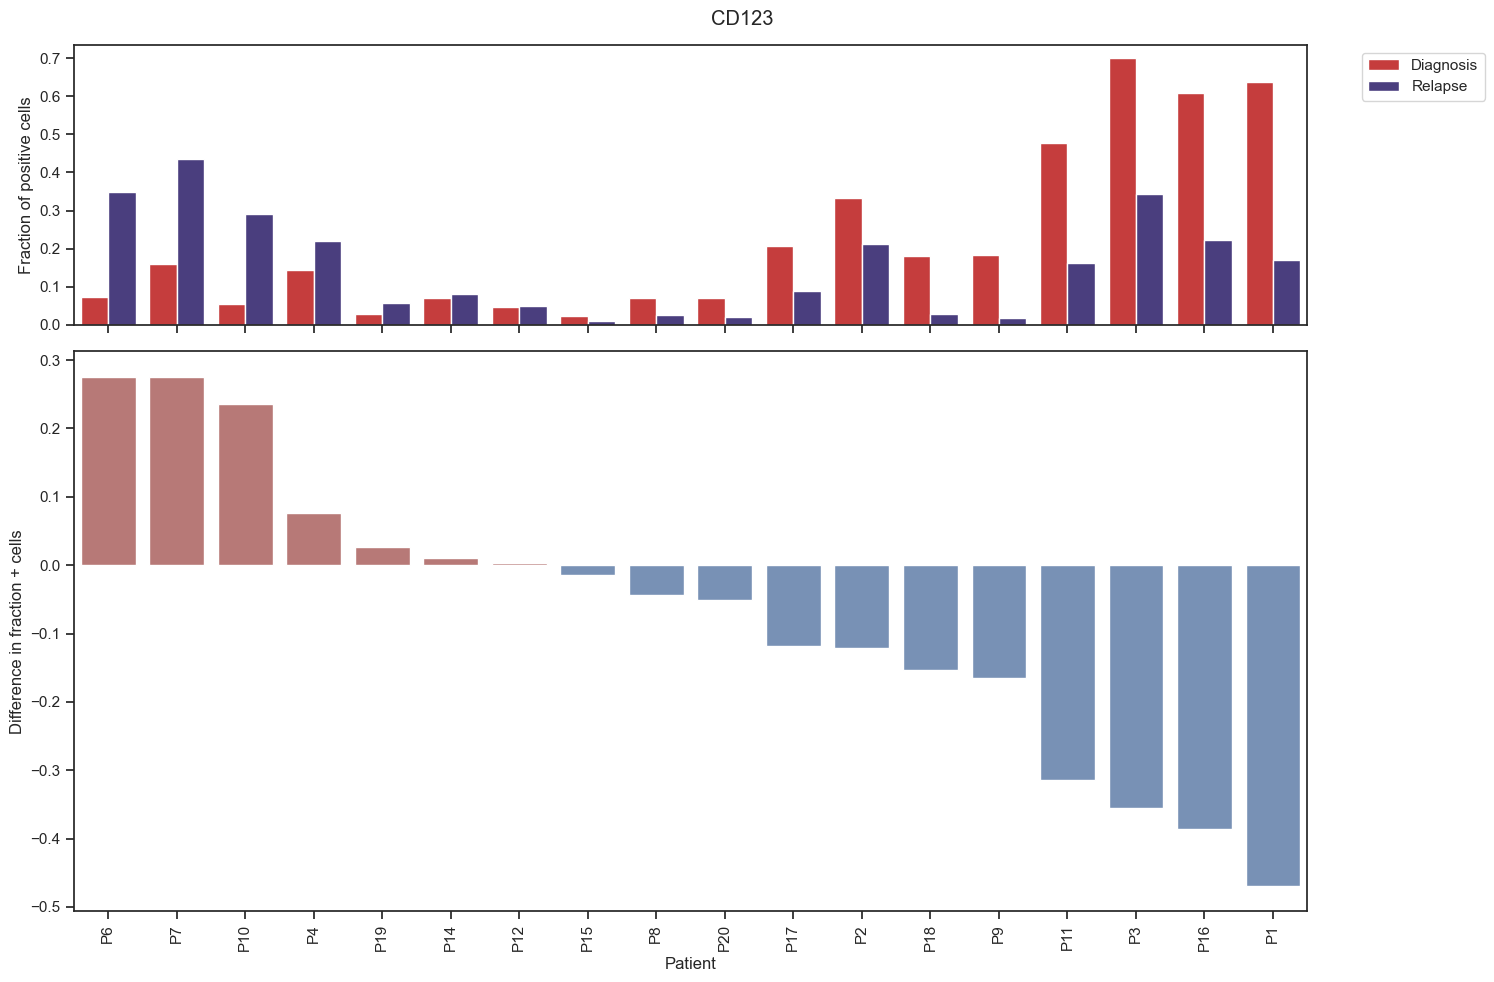

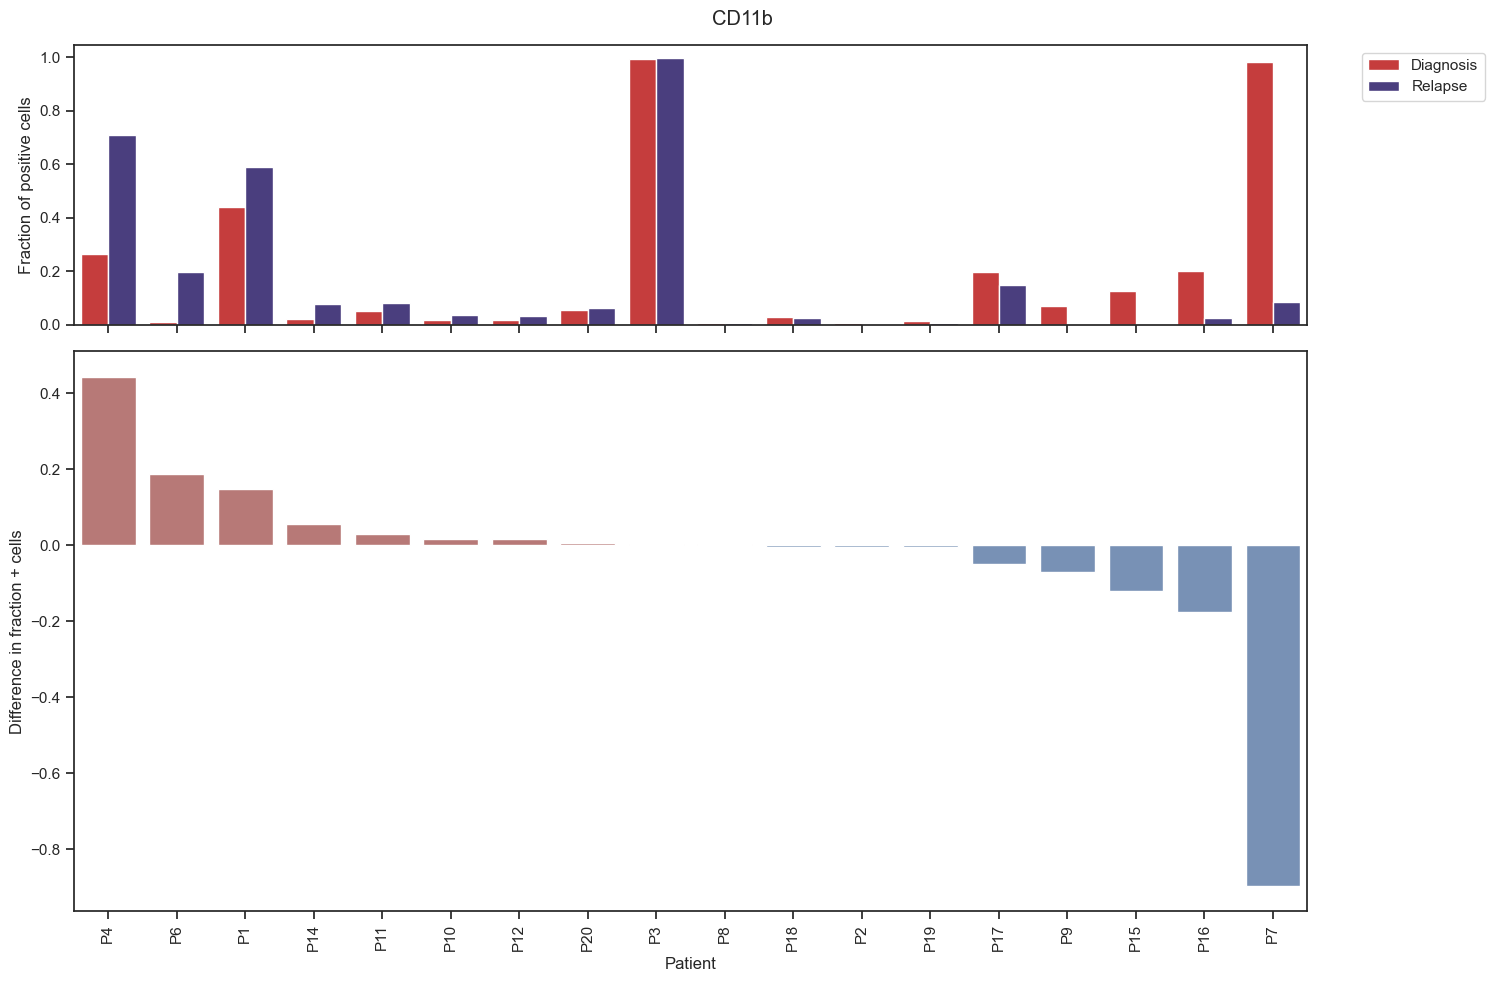

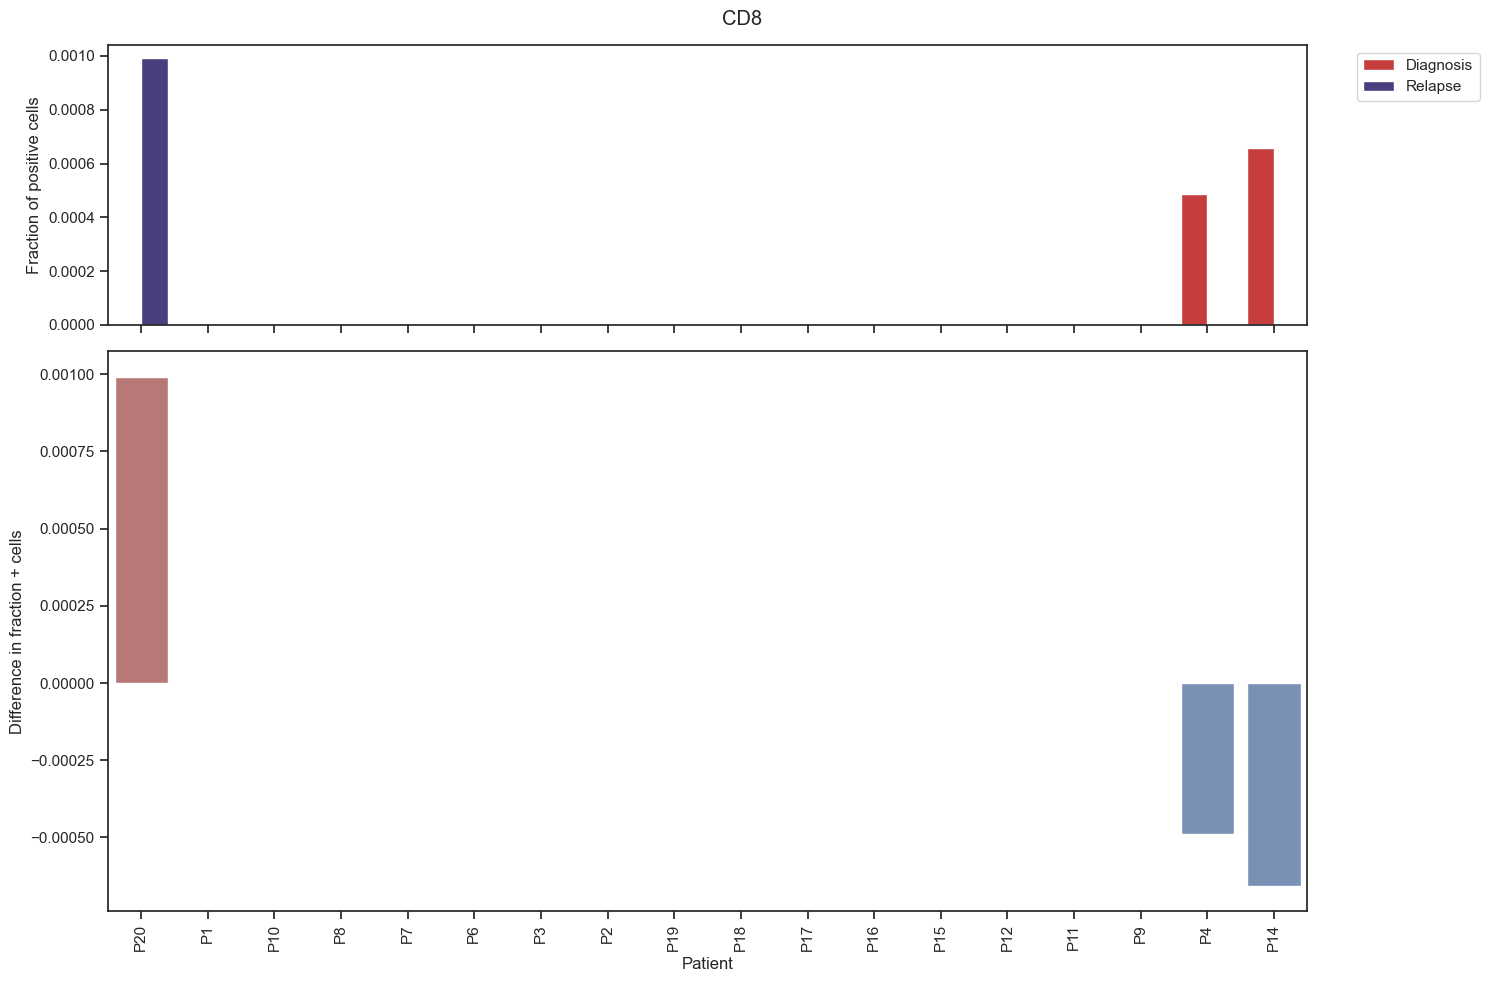

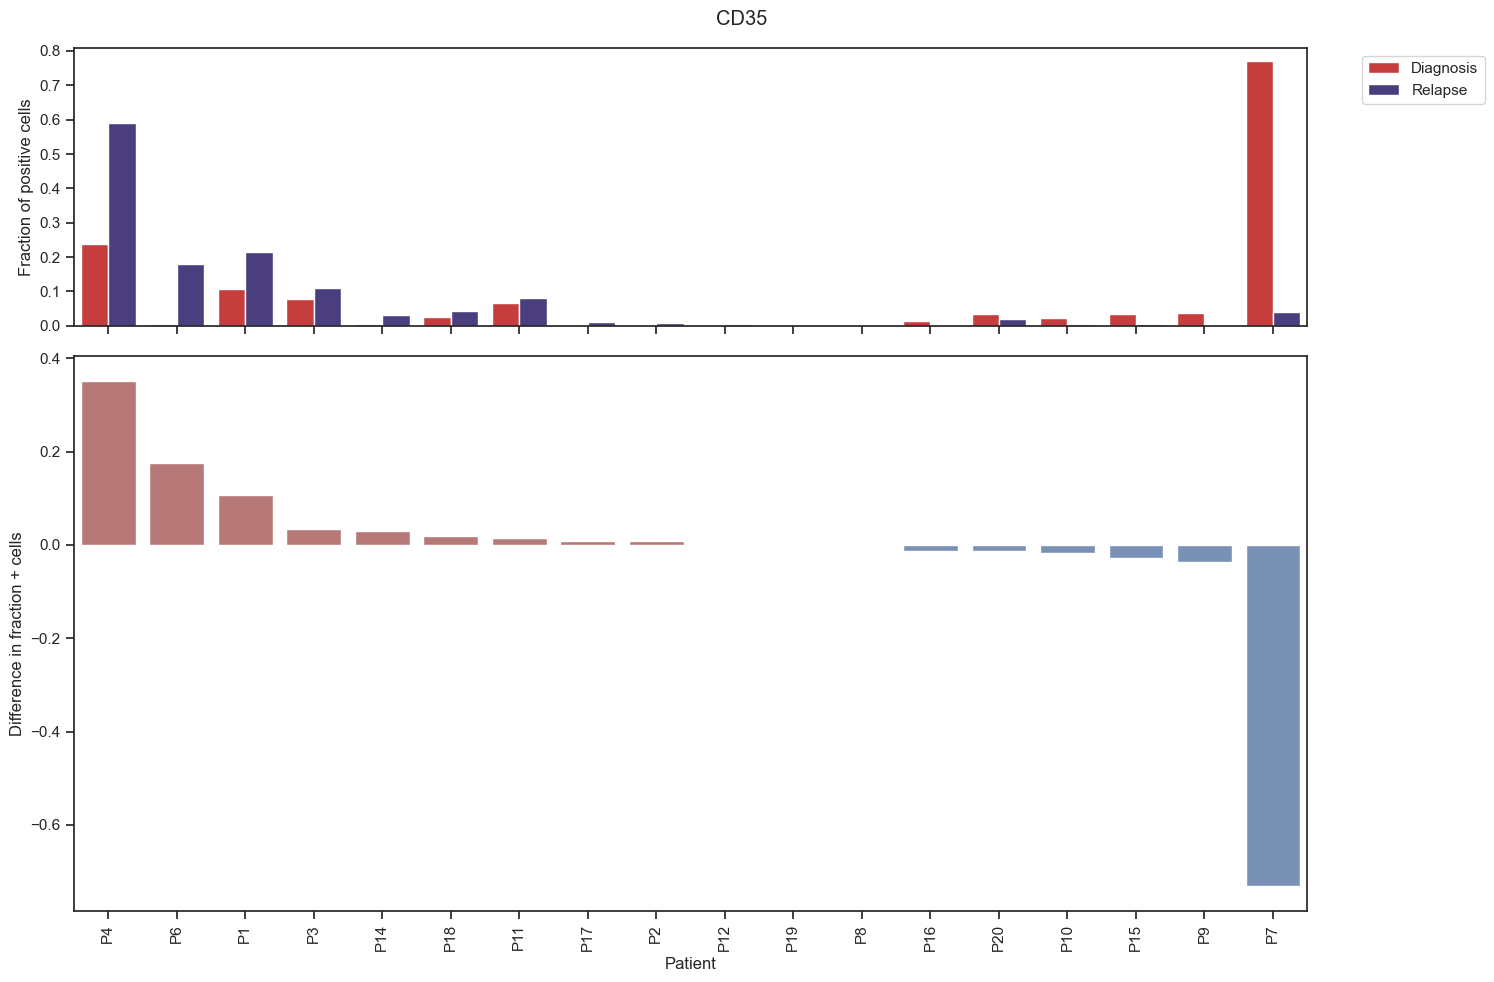

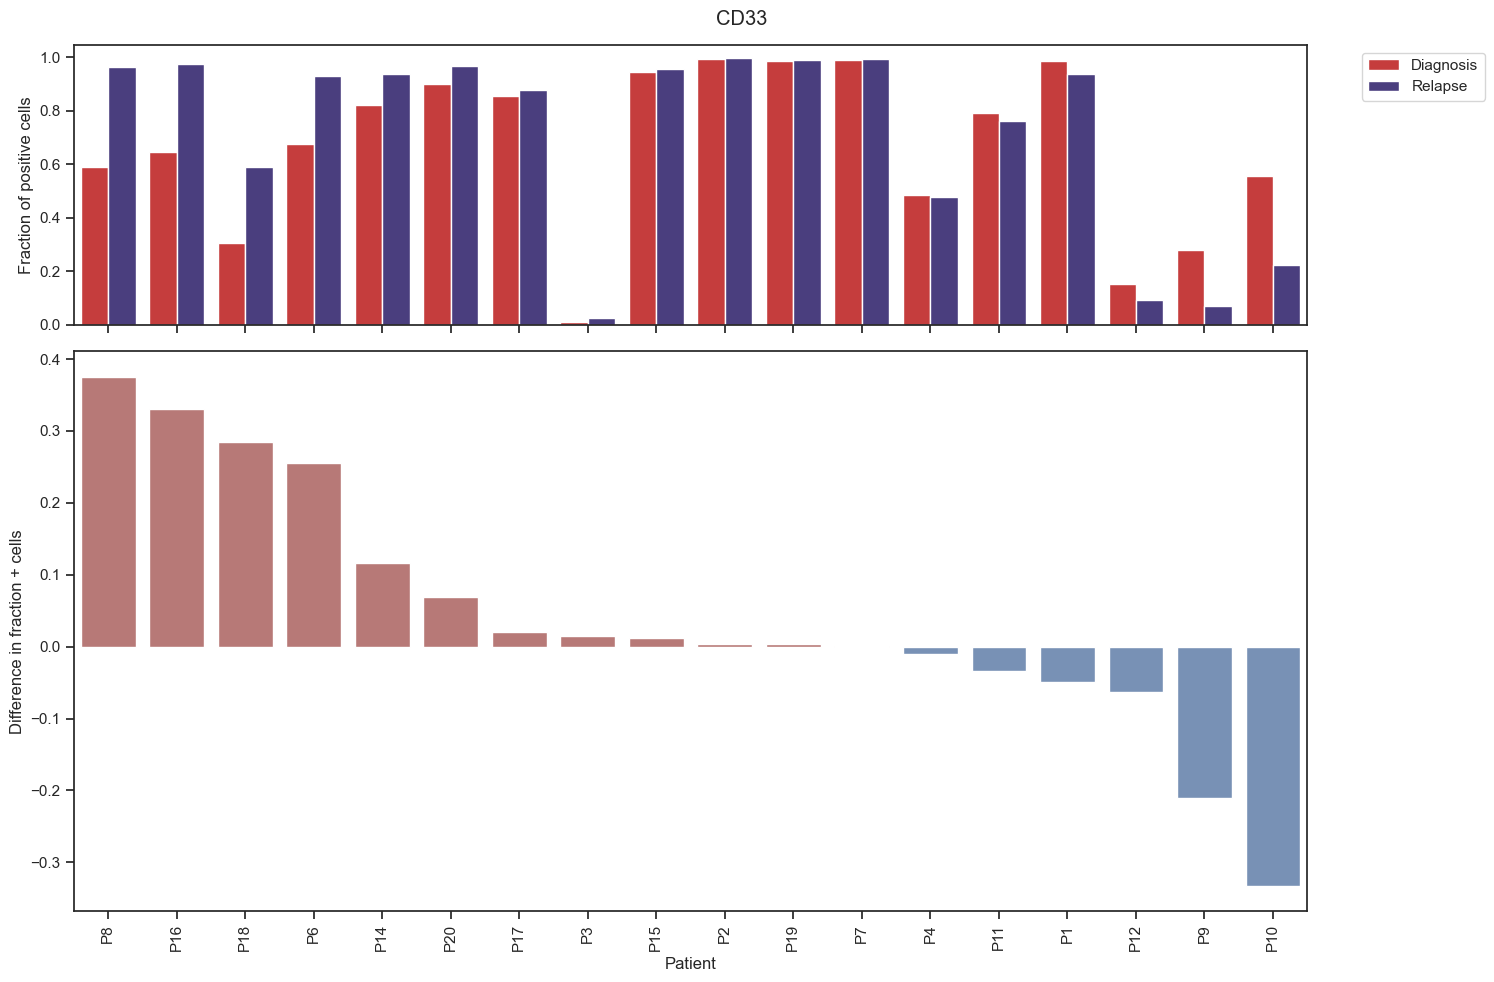

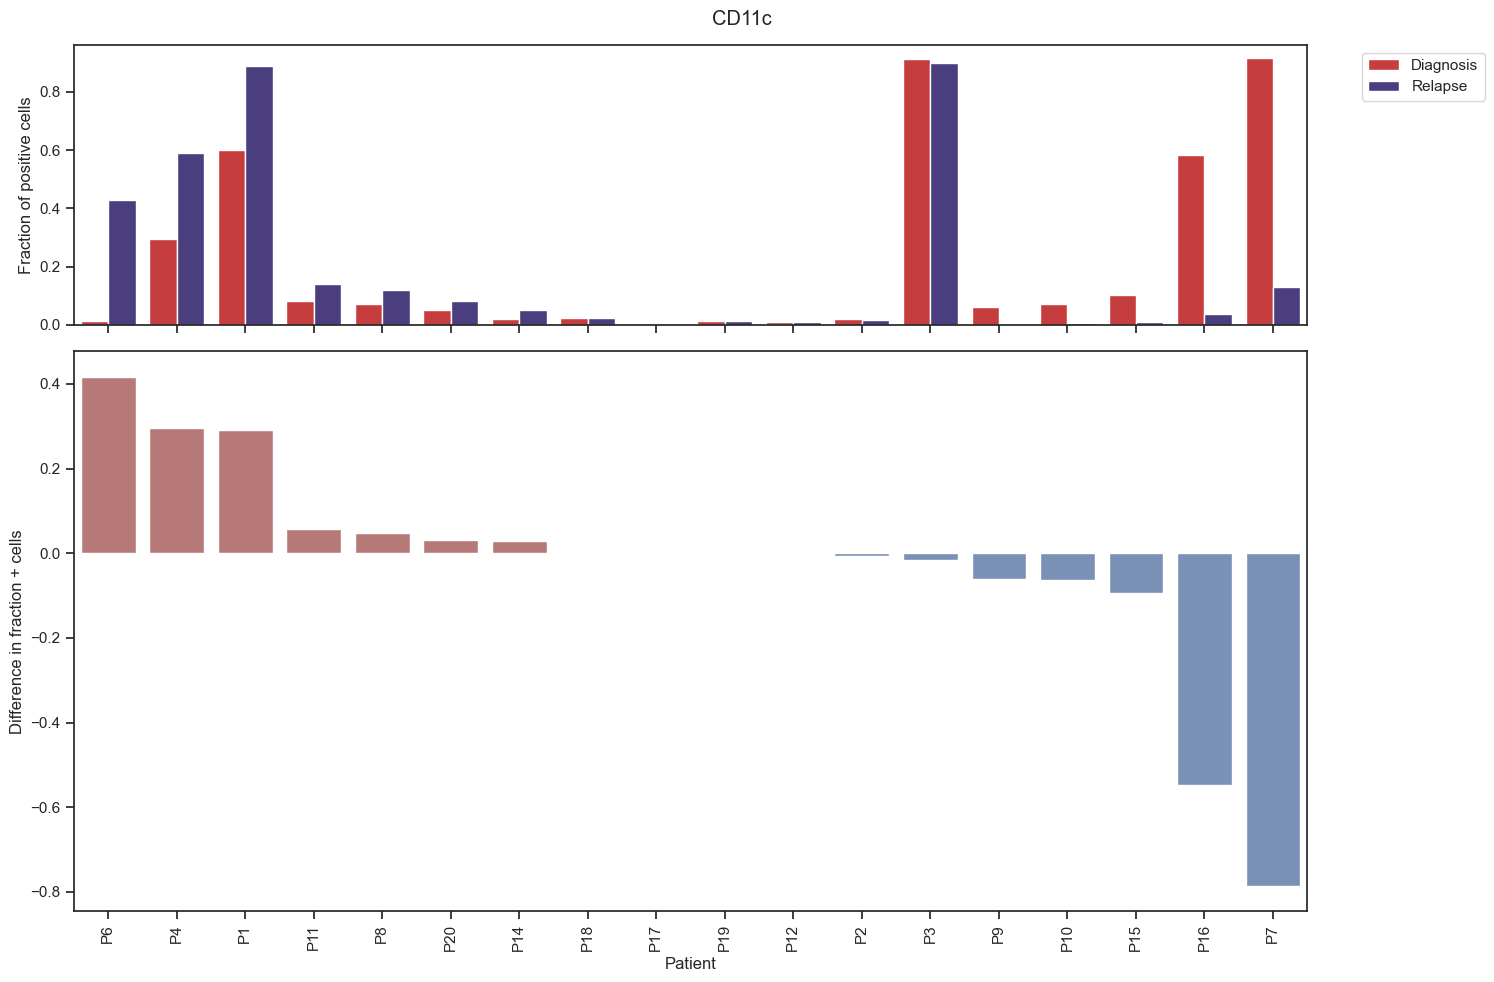

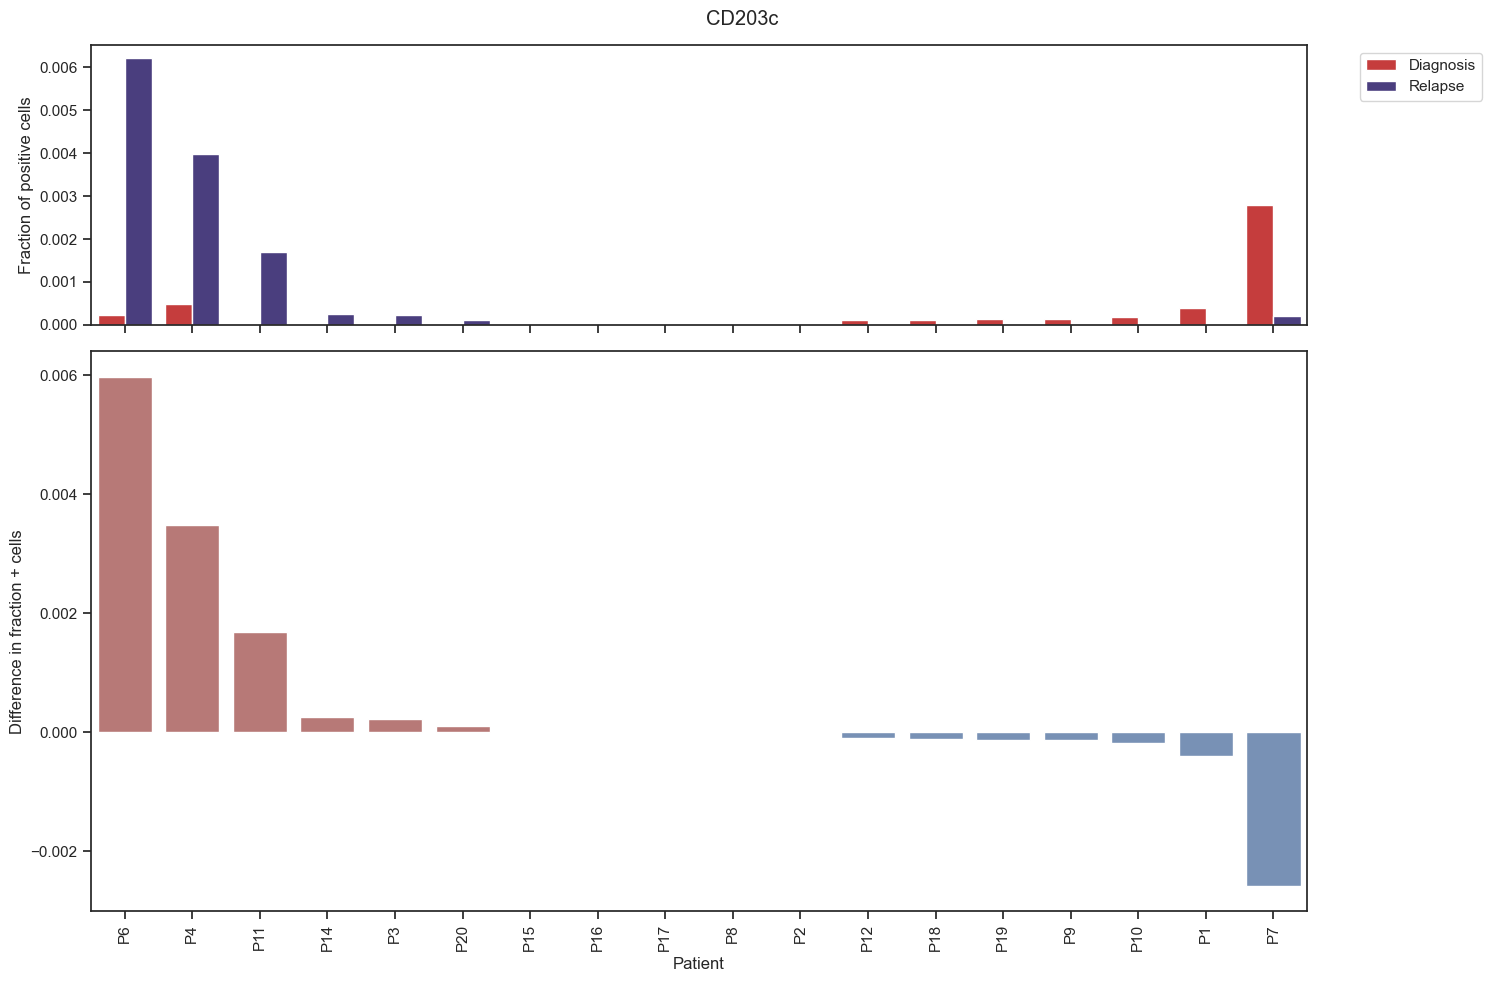

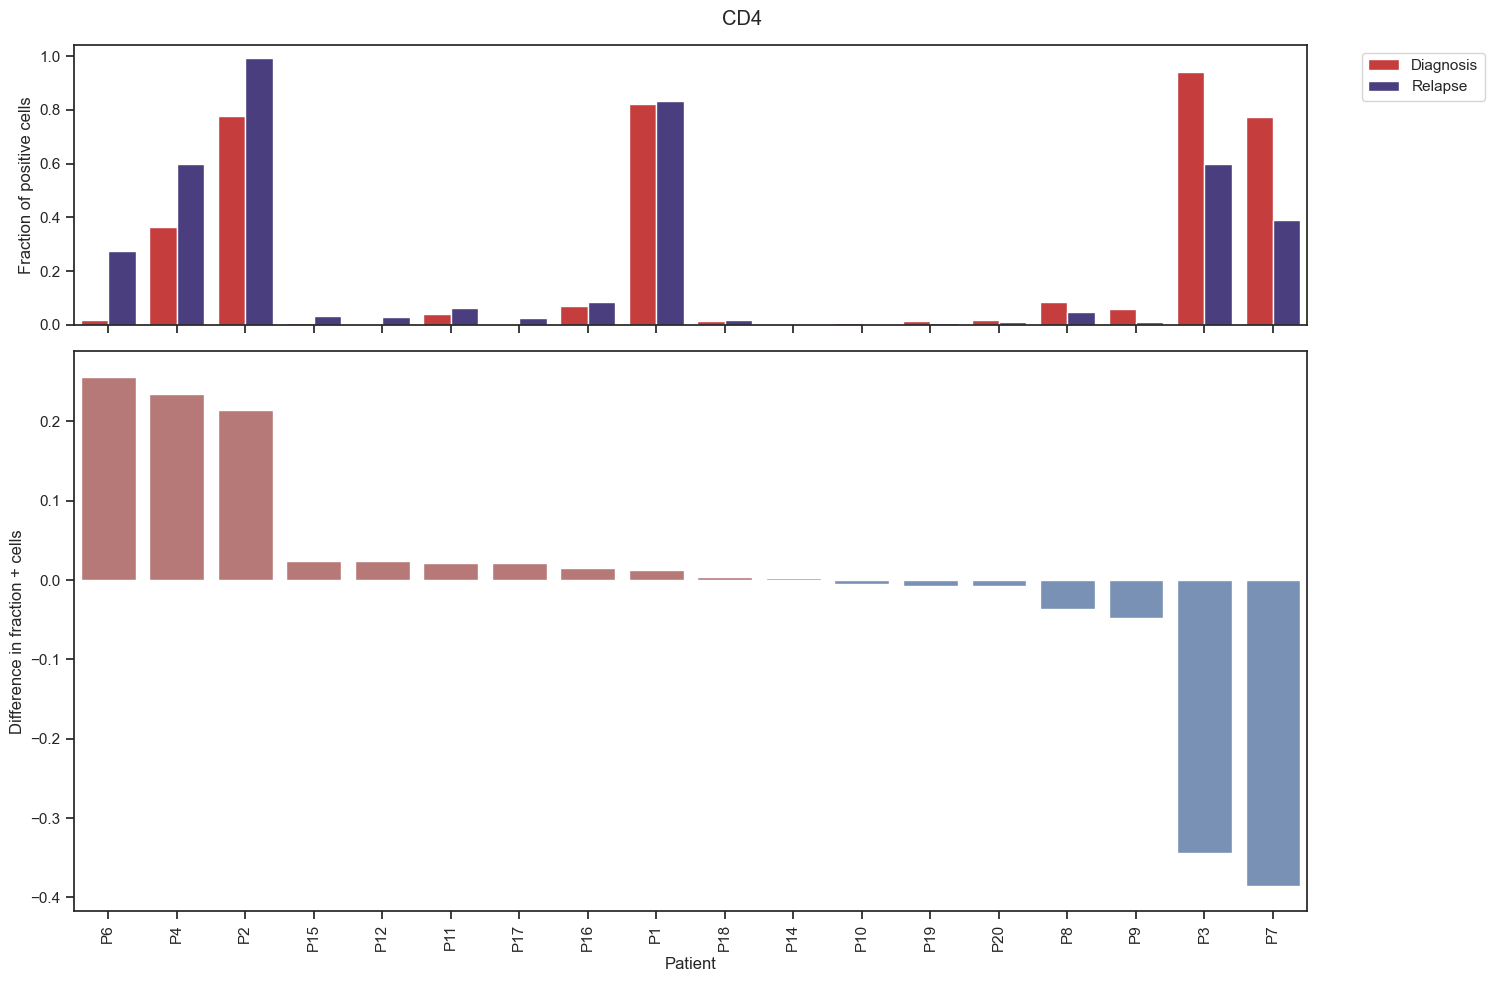

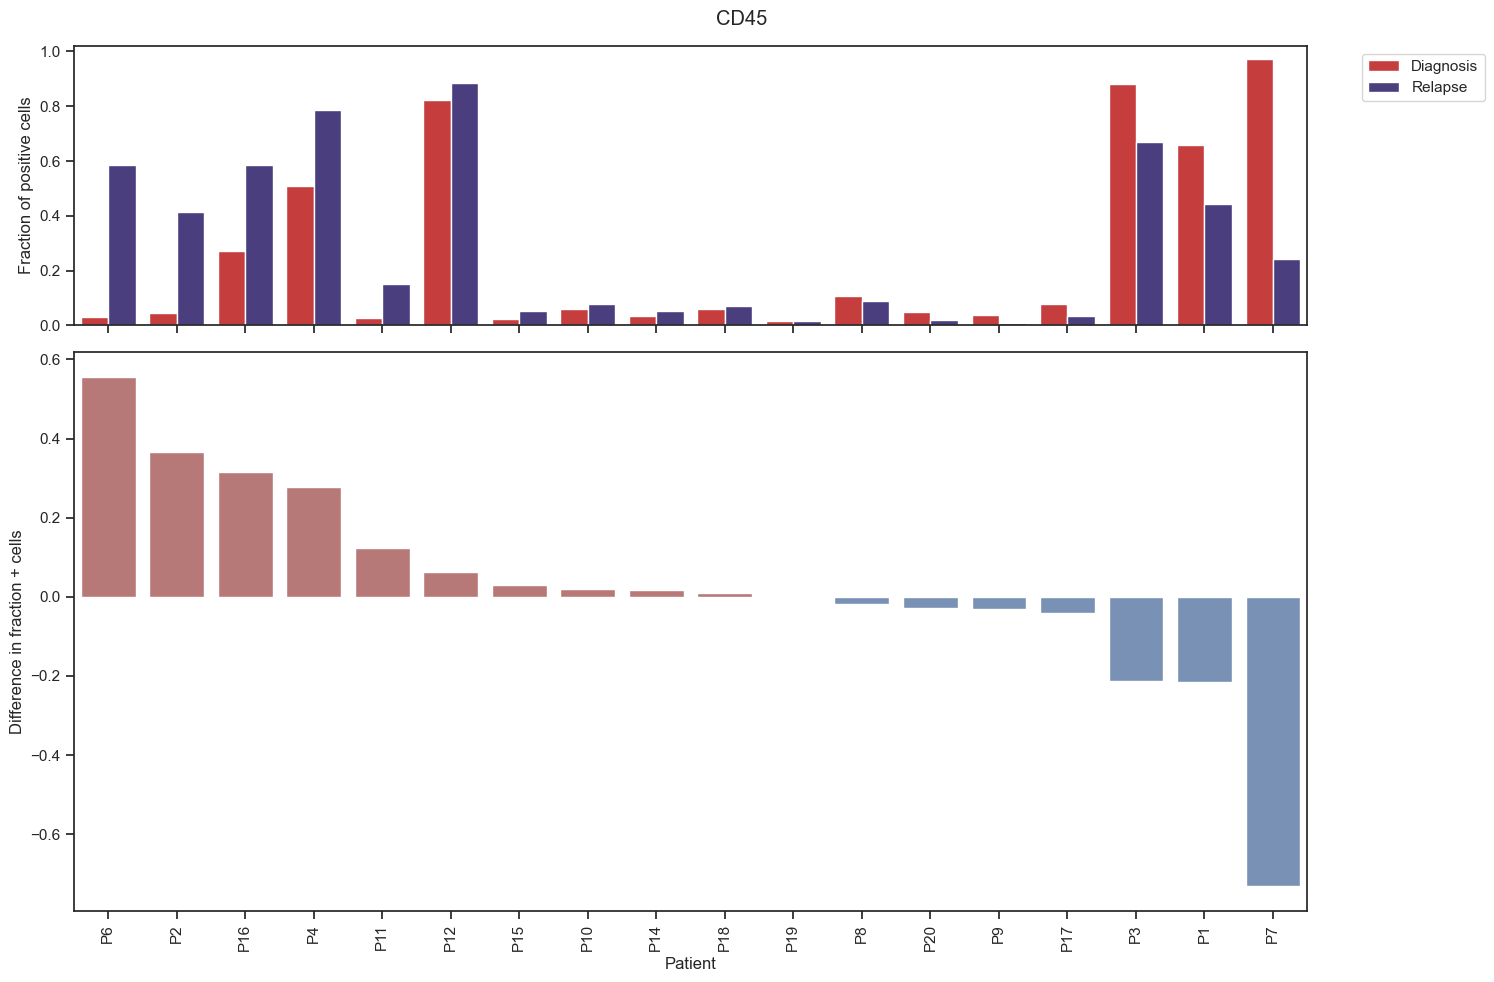

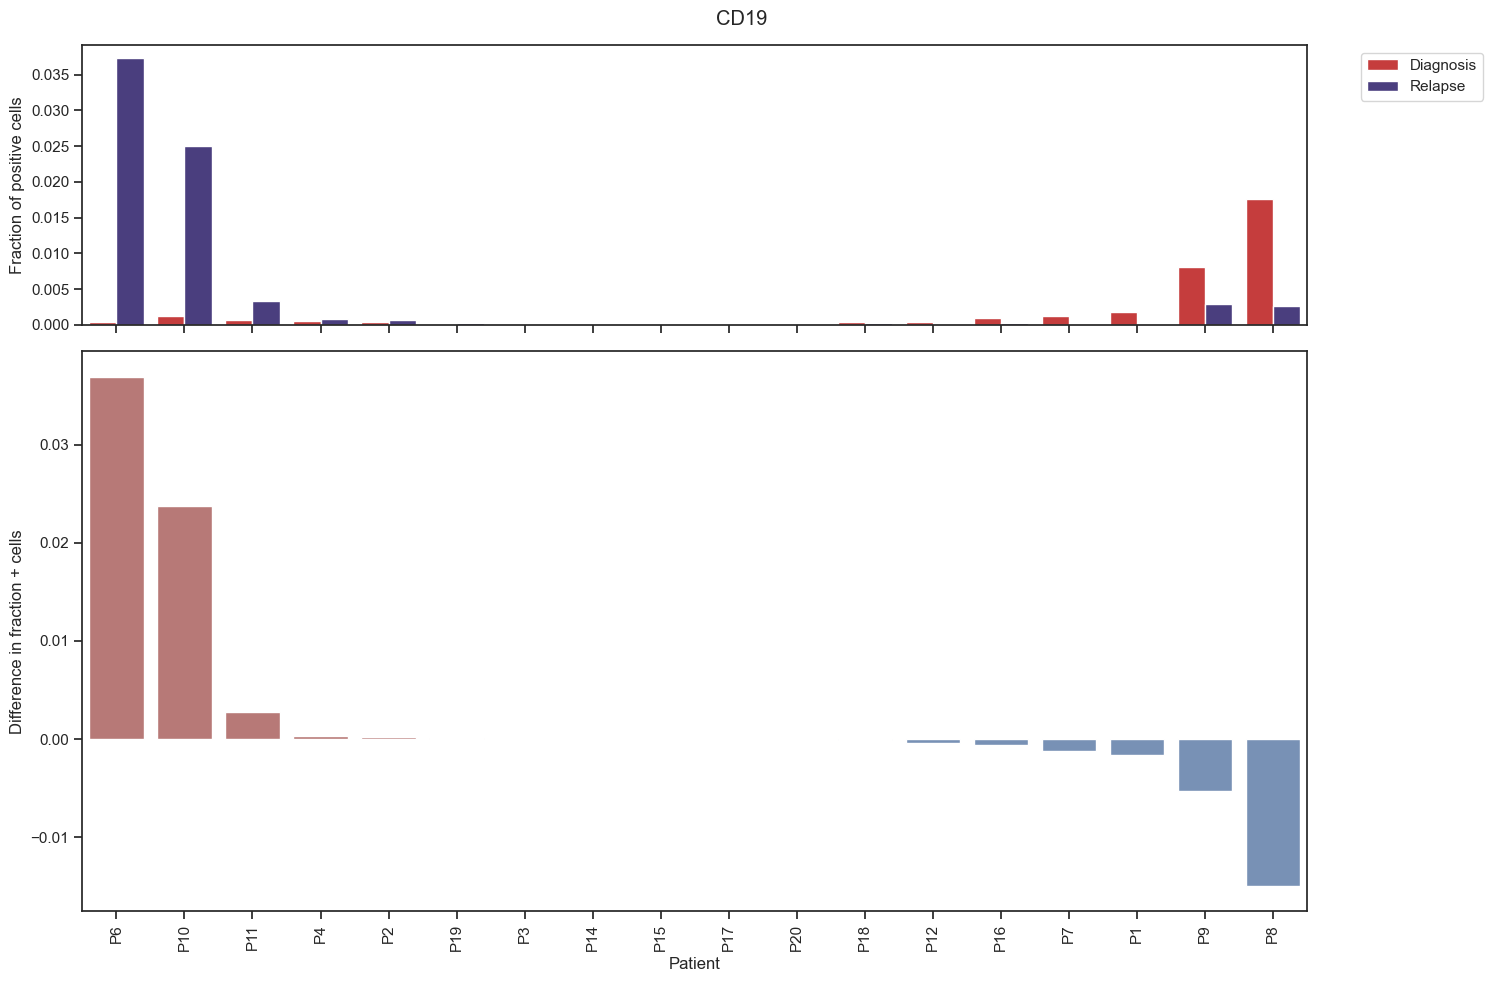

In [14]:
markers_to_save = ["CD123", "CD38", "CD34", "CD45RA"]

for marker in plot_data["marker"].unique():
    fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [1, 2]})
    plt_data = plot_data[plot_data["marker"]==marker].sort_values("difference", ascending=False).reset_index(drop=True)
    
    sns.barplot(ax=axes[0], data=num_pos_cells, x="PatientID", y=marker, hue="time_point", 
                palette=timepoints_cmap, order=plt_data["PatientID"])
    axes[0].xaxis.label.set_visible(False)
    axes[0].set_ylabel("Fraction of positive cells")
    axes[0].legend(bbox_to_anchor=(0.65,0.5,0.5,0.5))

    sns.barplot(ax=axes[1],data=plt_data, x="PatientID", y="difference", hue="color", palette=cmap,
               dodge=False, order=plt_data["PatientID"])
    axes[1].get_legend().remove()
    axes[1].set_ylabel("Difference in fraction + cells")



    plt.xticks(rotation = 90)
    plt.xlabel("Patient")
    fig.suptitle(marker)
    plt.tight_layout()
    
    if marker in markers_to_save:
        plt.savefig(f"{fig_dir}Change_of_cells_postitive_for_{marker}_incl_median_expr.pdf")
    plt.show()

In [67]:
unshown =  {
"FSC_A": ["P1", "P10", "P8", "P7", "P6", "P4", "P3", "P20", "P2", "P19", "P18", "P17", "P16", "P15", "P14", "P12", "P11", "P9"],
"FSC_A": ["P1", "P10", "P7", "P6", "P4", "P3", "P20", "P2", "P19", "P18", "P17", "P16", "P15", "P14", "P12", "P11", "P9"],
"CD38": ["P19"],
"CD117": ["P2", "P3"],
"CD14": ["P12", "P18", "P2", "P17", "P3"],
"CD71": ["P17", "P1", "P9"],
"HLA_DR": ["P8"],
"CD56": ["P10", "P12", "P16", "P1"],
"CD3": ["P9", "P14", "P15", "P17", "P8", "P2", "P4"],
"CD13": ["P17"],
"CD34": ["P16"],
"CD45RA": ["P9"],
"CD64": ["P12", "P17"],
"CD123": [],
"CD11b": ["P3", "P8"],
"CD8": ["P1", "P10", "P8", "P7", "P6", "P3", "P2", "P19", "P18", "P17", "P16", "P15", "P12", "P11", "P9"],
"CD35": ["P12", "P19", "P8"],
"CD33": ["P7"],
"CD11c": ["P18", "P17", "P19", "P12"],
"CD203c": ["P15", "P16", "P17", "P8", "P2"],
"CD4": [],
"CD45": ["P19"],
"CD19": ["P19", "P3", "P14", "P15", "P17", "P20", "P18"],
}

In [68]:
pos_cell_count = count_meta.groupby(["PatientID", "time_point"]).sum().reset_index(drop=False)
temp = pos_cell_count.copy()
temp[markers] = temp[markers].diff()
temp = temp[temp["time_point"]=="Relapse"].drop("time_point", axis=1)
cell_difference = pd.melt(temp, id_vars="PatientID", value_name="n_cells_difference", var_name="marker")

pos_cell_count = pd.melt(pos_cell_count, id_vars=["PatientID", "time_point"], value_name="n_cells", var_name="marker")
pos_cell_count = pos_cell_count.pivot(columns="time_point", index=["PatientID", "marker"], values="n_cells")
pos_cell_count = pos_cell_count.reset_index(drop=False)
pos_cell_count = pos_cell_count.rename(columns={"Diagnosis": "n cells diagnosis",
                                               "Relapse": "n cells relapse"})

all_data = plot_data.merge(cell_difference, on=["PatientID", "marker"]).merge(pos_cell_count, on=["PatientID", "marker"])
all_data = all_data.drop("color", axis=1)
all_data = all_data.rename(columns={"difference": "fraction difference"})

In [69]:
all_data

,PatientID,marker,fraction difference,n_cells_difference,n cells diagnosis,n cells relapse
0,P1,FSC_A,0.000000,1616.0,4994,6610
1,P10,FSC_A,0.000000,2098.0,5660,7758
2,P11,FSC_A,0.000000,-8008.0,9192,1184
3,P12,FSC_A,0.000000,-669.0,9582,8913
4,P14,FSC_A,0.000000,405.0,7622,8027
...,...,...,...,...,...,...
409,P4,CD19,0.000307,1.0,1,2
410,P6,CD19,0.036907,3.0,3,6
411,P7,CD19,-0.001197,-3.0,3,0
412,P8,CD19,-0.014932,-110.0,127,17


In [70]:
unshown_data = []
for k, v in unshown.items():
    subset = all_data[(all_data["marker"]==k) & (all_data["PatientID"].isin(v))]
    unshown_data.append(subset)
    
unshown_data = pd.concat(unshown_data)

In [71]:
all_data.to_excel(f"{fig_dir}all_differences.xlsx",
                        index=False)
unshown_data.to_excel(f"{fig_dir}unshown_difference.xlsx",
                        index=False)

# Clustering marker changes

In [15]:
pos_cell_meta = difference.pop("PatientID")
blast_pos_cell_markers = difference.copy()

In [16]:
pos_cell_meta = pd.merge(pos_cell_meta, patient_meta, how="left", on="PatientID")
pos_cell_meta = pos_cell_meta.set_index("PatientID")

In [17]:
marker_order = ["CD64", "CD11c", "CD11b", "CD14", "CD35", "CD4", "CD45", 
                "CD45RA", "CD38", "CD117", "CD13", "CD56", "HLA_DR",
               "CD123", "CD34", "CD33", "CD71", "CD19", "CD8", "CD3", "CD203c", "FSC_A", "SSC_A"]

In [18]:
pos_cell_meta

,patient_id,Gender,Race,Ethnicity,Karyotype,FLT3 results,Allelic ratio,NPM1 mutation status,CEBPA mutation status,Fusion,...,Bone marrow leukemic blast percentage (%) at diagnosis,Bone marrow leukemic blast percentage (%) at relapse,MRD status at end of induction 1,Percent MRD (%),SCT status,Age in days at study entry,Days to relapse from study entry,Days to OS from study entry,Life status,Days diff
PatientID,,,,,,,,,,,,,,,,,,,,,
P1,PAUMTZ,Male,White,Not Hispanic or Latino,"46,XY, cryp ins(10;11)(p12;q23q23)[20]",Wild-type,.,Negative,Negative,KMT2A,...,86.0,82,Negative,0.00,SCT not received,3639,327,659,Dead,332
P10,PAWWZL,Male,White,Not Hispanic or Latino,"46,XY,del(7)(q22q34),t(8;21)(q22;q22)[20]",Wild-type,.,Negative,Negative,RUNX1_RUNX1T1,...,63.0,95,Negative,0.00,SCT received after relapse,2481,219,1550,Alive,1331
P11,PAXMIJ,Female,White,Not Hispanic or Latino,"46,XX,t(8;21)(q22;q22)[2]/45,idem,-X[7]/46,ide...",Wild-type,.,Negative,Negative,RUNX1_RUNX1T1,...,78.0,6,Positive,0.60,SCT received after relapse,2280,288,1316,Alive,1028
P12,PAUZVP,Male,Black or African American,Not Hispanic or Latino,"87(<4n),XXYY,+1,inv(1)(p36.1q44)x3,-2,+3,add(3...",Wild-type,.,Negative,Negative,other,...,79.0,75,Positive,5.00,SCT received in follow-up (before relapse),5593,733,1044,Dead,311
P14,PAVEDT,Male,White,Not Hispanic or Latino,"47,XY,+Y[14]/46,XY[6]",Wild-type,.,Positive,Negative,other,...,92.4,93,Positive,4.80,SCT received after relapse,2164,494,2448,Alive,1954
P15,PAVTDU,Female,White,Not Hispanic or Latino,"46,XX,der(8)inv(8)(p22q24.2)inv(8)(q12q22)inv(...",Wild-type,.,Negative,Negative,other,...,50.0,58,Negative,0.00,SCT received after relapse,4243,434,2053,Alive,1619
P16,PAVTLN,Female,White,Not Hispanic or Latino,"46,XX,t(3;5)(q25.3;q35.1)[20]",Wild-type,.,Negative,Negative,other,...,90.0,56,Negative,0.00,SCT not received,5440,496,635,Dead,139
P17,PAVZEC,Female,White,Not Hispanic or Latino,"47,XX,der(9)add(9)(q34)del(9)(q12q22),+10,t(12...",Wild-type,.,Negative,Negative,other,...,96.0,90,Negative,0.00,SCT received after relapse,5131,759,1988,Alive,1229
P18,PAWXIA,Female,Black or African American,Not Hispanic or Latino,"46,XX,dup(8)(q11.2q24)[2]/46,XX[18]",Wild-type,.,Negative,Negative,other,...,79.0,75,Negative,0.04,SCT received after relapse,771,207,339,Dead,132


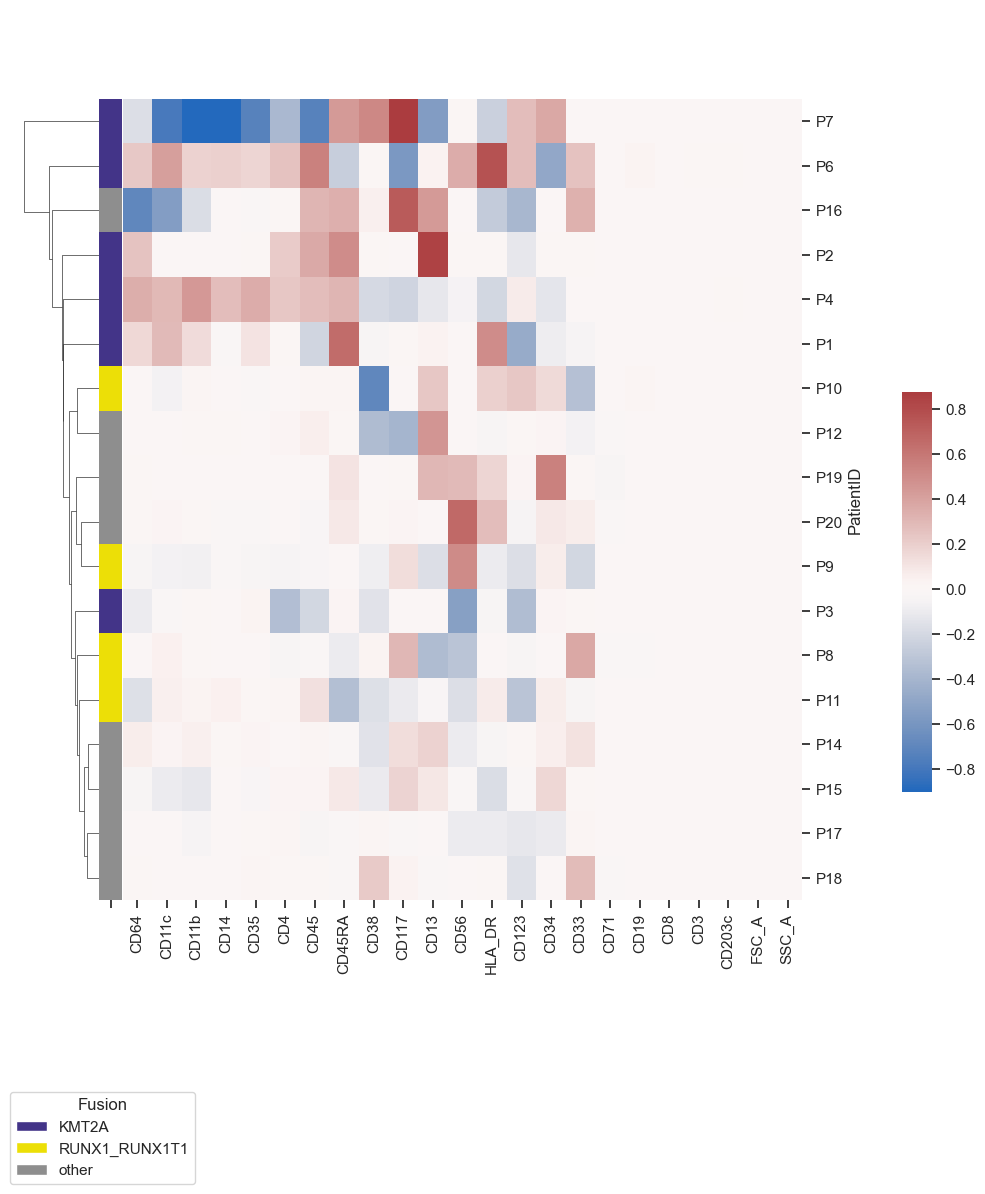

In [33]:
row_labels = pos_cell_meta["Fusion"]
row_labels = ["KMT2A" if "KMT2A" in label else label for label in pos_cell_meta["Fusion"].astype(str)]
row_labels = ["other" if not label  in ["KMT2A", "RUNX1_RUNX1T1"] else label for label in row_labels ]
row_labels = pd.Series(row_labels, index=pos_cell_meta.index)
lut = dict(zip(row_labels.unique(), [default_rgba["blue"], default_rgba["yellow"], default_rgba["grey"]]))
row_colors = row_labels.map(lut)

plt_data = blast_pos_cell_markers.copy()
plt_data.index=pos_cell_meta.index

g = sns.clustermap(plt_data[marker_order], dendrogram_ratio=(0.1,0.1), cmap="vlag", center=0,
               yticklabels=True, xticklabels=True, row_colors=row_colors, col_cluster=False)
# Rotate yticklabels
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

# Move colorbar to prevent overlap
g.fig.subplots_adjust(right=0.8)
g.ax_cbar.set_position((0.9, .2, .03, .4))

# Plot legend
handles = [Patch(facecolor=lut[name]) for name in lut]
L1 = plt.legend(handles, lut, title="Fusion",
           bbox_to_anchor=(0, -0.2), bbox_transform=plt.gcf().transFigure, loc='lower left')
plt.savefig(f"{fig_dir}pos_cells_marker_changes_clustered.pdf",
           bbox_inches="tight")

In [ ]:
        "FSC_A":  0,
        "SSC_A":  0,
        "CD38":   5460,
        "CD117":  2610,
        "CD14":   6220,
        "CD71":   2900,
        "HLA_DR": 2180,
        "CD56":   2650,
        "CD3":    3400,
        "CD13":   6640,
        "CD34":   3570,
        "CD45RA": 3700,
        "CD64":   2770,
        "CD123":  3820,
        "CD11b":  3820,
        "CD8":    3820,
        "CD35":   2860,
        "CD33":   1930,
        "CD11c":  2860,
        "CD42b":  2860,
        "CD203c": 5460,
        "CD4":    4960,
        "CD45":   4960,
        "CD19":   3030,
    }